[Table of Contents](./table_of_contents.ipynb)

# The g-h Filter

In [1]:
%matplotlib inline

In [4]:
#format the book
import sys
sys.path.append('/home/an-nemenko/repo/Kalman-and-Bayesian-Filters-in-Python')

import book_format
book_format.set_style()

Before we start, be sure you understand how to use [Jupyter Notebooks](http://jupyter.org/), and are familiar with the [SciPy](https://scipy.org), [NumPy](http://www.numpy.org/), and [Matplotlib](https://matplotlib.org/) packages, as they are used throughout this book. The Preface contains an introduction to these packages.

## Building Intuition via Thought Experiments

Imagine that we live in a world without scales - the devices you stand on to weigh yourself. One day at work a co-worker comes running up to you and announces her invention of a 'scale' to you. After she explains, you eagerly stand on it and announce the results: "172 lbs". You are ecstatic - for the first time in your life you know what you weigh. More importantly, dollar signs dance in your eyes as you imagine selling this device to weight loss clinics across the world! This is fantastic!

Another co-worker hears the commotion and comes over to find out what has you so excited. You explain the invention and once again step onto the scale, and proudly proclaim the result: "161 lbs." And then you hesitate, confused.

"It read 172 lbs a few seconds ago", you complain to your co-worker. 

"I never said it was accurate," she replies.

Sensors are inaccurate. This is the motivation behind a huge body of work in filtering, and solving this problem is the topic of this book. I could just provide the solutions that have been developed over the last half century, but these solutions were developed by asking very basic, fundamental questions into the nature of what we know and how we know it. Before we attempt the math, let's follow that journey of discovery, and see if it informs our intuition about filtering. 

**Try Another Scale**

Is there any way we can improve upon this result? The obvious, first thing to try is get a better sensor. Unfortunately, your co-worker informs you that she has built 10 scales, and they all operate with about the same accuracy. You have her bring out another scale, and you weigh yourself on one, and then on the other. The first scale (A) reads "160 lbs", and the second (B) reads "170 lbs". What can we conclude about your weight?

Well, what are our choices?

* We could choose to only believe A, and assign 160lbs to our weight estimate.
* We could choose to only believe B, and assign 170lbs to our weight.
* We could choose a number less than both A and B.
* We could choose a number greater than both A and B.
* We could choose a number between A and B.

The first two choices are plausible, but we have no reason to favor one scale over the other. Why would we choose to believe A instead of B? We have no reason for such a belief. The third and fourth choices are irrational. The scales are admittedly not very accurate, but there is no reason at all to choose a number outside of the range of what they both measured. The final choice is the only reasonable one. If both scales are inaccurate, and as likely to give a result above my actual weight as below it, more often than not the answer is somewhere between A and B. 

In mathematics this concept is formalized as [*expected value*](https://en.wikipedia.org/wiki/Expected_value), and we will cover it in depth later. For now ask yourself what would be the 'usual' thing to happen if we took one million readings. Some of the times both scales will read too low, sometimes both will read too high, and the rest of the time they will straddle the actual weight. If they straddle the actual weight then certainly we should choose a number between A and B. If they don't straddle then we don't know if they are both too high or low, but by choosing a number between A and B we at least mitigate the effect of the worst measurement. For example, suppose our actual weight is 180 lbs. 160 lbs is a big error. But if we choose a weight between 160 lbs and 170 lbs our estimate will be better than 160 lbs. The same argument holds if both scales returned a value greater than the actual weight.

We will deal with this more formally later, but for now I hope it is clear that our best estimate is the average of A and B. 

$$\frac{160+170}{2} = 165$$

We can look at this graphically. I have plotted the measurements of A and B with an assumed error of $\pm$ 8 lbs. The measurements falls between 160 and 170 so the only weight that makes sense must lie within 160 and 170 lbs. 

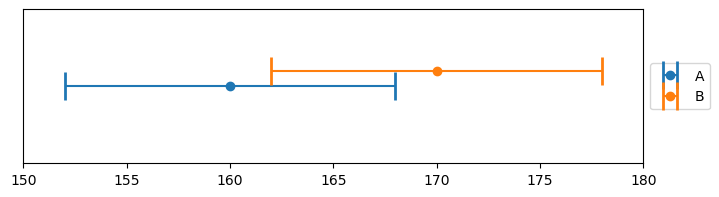

In [46]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

A word on how I generated this plot. I import code from the module book_plots in the `kf_book` subdirectory. Generating this plot takes a lot of boilerplate Python that isn't interesting to read. I take this tack often in the book. When the cell is run `plot_errorbars()` gets called and the plot is inserted into the book.

If this is your first time using [Jupyter Notebook](http://jupyter.org/), the code above is in a *cell*. The text "In [2]:" labels this as a cell where you can enter input, and the number in the bracket denotes that this cell was run second. To run the cell, click on it with your mouse so that it has focus, then press CTRL+ENTER on the keyboard. As we continue you will be able to alter the code inside the cells and rerun them. Try changing the values "160", "170", and "8" to some other value and run the cell. The printed output should change depending on what you entered.

If you want to view the code for plot_errorbars, either open it in an editor, or create a new cell and type the function name followed by two question marks. Press Ctrl+Enter, and your browser will open a window displaying the source code. This is a feature of Jupyter Notebooks. If you want to just view the documentation for the function, do the same but with one question mark.

```Python

    plot_errorbars??
```
or
```Python
    plot_errorbars?
```

So 165 lbs looks like a reasonable estimate, but there is more information here that we might be able to take advantage of. The only weights that are possible lie in the intersection between the error bars of A and B. For example, a weight of 161 lbs is impossible because scale B could not give a reading of 170 lbs with a maximum error of 8 pounds. Likewise a weight of 169 lbs is impossible because scale A could not give a reading of 160 lbs with a maximum error of 8 lbs. In this example the only possible weights lie in the range of 162 to 168 lbs.

That doesn't yet allow us to find a better weight estimate, but let's play 'what if' some more. What if we are now told that A is three times more accurate than B? Consider the 5 options we listed above. It still makes no sense to choose a number outside the range of A and B, so we will not consider those. It perhaps seems more compelling to choose A as our estimate - after all, we know it is more accurate, why not use it instead of B? Can B possibly improve our knowledge over A alone?

The answer, perhaps counter intuitively, is yes, it can. First, let's look at the same measurements of A=160 and B=170, but with the error of A $\pm$ 3 lbs and the error of B is 3 times as much, $\pm$ 9 lbs.

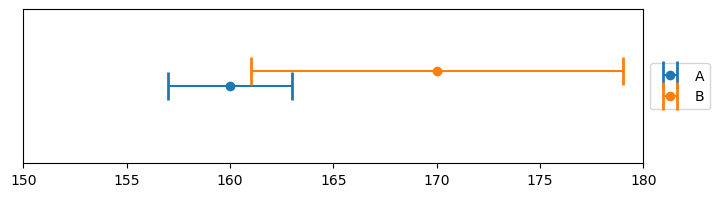

In [47]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

The overlap of the error bars of A and B are the only possible true weight. This overlap is smaller than the error in A alone. More importantly, in this case we can see that the overlap doesn't include 160 lbs or 165 lbs. If we only used the measurement from A because it is more accurate than B we would give an estimate of 160 lbs. If we average A and B we would get 165 lbs. Neither of those weights are possible given our knowledge of the accuracy of the scales. By including the measurement of B we would give an estimate somewhere between 161 lbs and 163 lbs, the limits of the intersections of the two error bars.

Let's take this to the extreme limits.  Assume we know scale A is accurate to 1 lb. In other words, if we truly weigh 170 lbs, it could report 169, 170, or 171 lbs. We also know that scale B is accurate to 9 lbs. We do a weighing on each scale, and get A=160, and B=170. What should we estimate our weight to be? Let's look at that graphically.

Наложение планок погрешности A и B — это единственный возможный истинный вес. Это наложение меньше, чем ошибка только в A. Что еще важнее, в этом случае мы видим, что наложение не включает 160 фунтов или 165 фунтов. Если бы мы использовали только измерение от A, потому что оно точнее, чем B, мы бы дали оценку в 160 фунтов. Если мы усредним A и B, мы получим 165 фунтов. Ни один из этих весов невозможен, учитывая наши знания о точности весов. Включая измерение B, мы бы дали оценку где-то между 161 фунтом и 163 фунтами, пределами пересечений двух планок погрешности.

Давайте доведем это до крайних пределов. Предположим, что мы знаем, что весы A имеют точность до 1 фунта. Другими словами, если мы действительно взвешиваем 170 фунтов, они могут показать 169, 170 или 171 фунт. Мы также знаем, что весы B имеют точность до 9 фунтов. Мы делаем взвешивание на каждых весах и получаем A=160, а B=170. Какому примерно весу мы должны соответствовать? Давайте посмотрим на это графически.

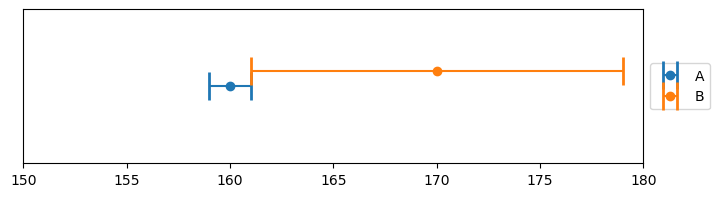

In [48]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

Here we can see that the only possible weight is 161 lbs. This is an important result. With two relatively inaccurate sensors we are able to deduce an extremely accurate result.

**So two sensors, even if one is less accurate than the other, is better than one.** I will harp on this for the remainder of the book. We never throw information away, no matter how poor it is. We will be developing math and algorithms that allow us to include all possible sources of information to form the best estimate possible.

However, we have strayed from our problem. No customer is going to want to buy multiple scales, and besides, we initially started with an assumption that all scales were equally (in)accurate. This insight of using all measurements regardless of accuracy will play a large role later, so don't forget it.

What if I have one scale, but I weigh myself many times? We concluded that if we had two scales of equal accuracy we should average the results of their measurements. What if I weigh myself 10,000 times with one scale? We have already stated that the scale is equally likely to return a number too large as it is to return one that is too small. It is not that hard to prove that the average of a large number of weights will be very close to the actual weight, but let's write a simulation for now. I will use NumPy, part of the [SciPy](https://scipy.org/) ecosystem for numerical computation.

Здесь мы видим, что единственный возможный вес — 161 фунт. Это важный результат. С двумя относительно неточными датчиками мы можем вывести чрезвычайно точный результат.

**Так что два датчика, даже если один менее точен, чем другой, лучше, чем один.** Я буду повторять это до конца книги. Мы никогда не выбрасываем информацию, какой бы плохой она ни была. Мы будем разрабатывать математику и алгоритмы, которые позволят нам включить все возможные источники информации, чтобы сформировать наилучшую возможную оценку.

Однако мы отклонились от нашей проблемы. Ни один клиент не захочет покупать несколько весов, и, кроме того, мы изначально исходили из предположения, что все весы одинаково (не)точны. Это понимание использования всех измерений независимо от точности сыграет большую роль позже, так что не забывайте об этом.

Что, если у меня одни весы, но я взвешиваюсь много раз? Мы пришли к выводу, что если у нас есть двое весов одинаковой точности, мы должны усреднить результаты их измерений. Что, если я взвешу себя 10 000 раз на одних весах? Мы уже говорили, что весы с одинаковой вероятностью вернут как слишком большое, так и слишком маленькое число. Не так уж сложно доказать, что среднее значение большого количества весов будет очень близко к фактическому весу, но давайте пока напишем симуляцию. Я буду использовать NumPy, часть экосистемы [SciPy](https://scipy.org/) для численных вычислений.

In [49]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 164.9783


The exact number printed depends on your random number generator, but it should be very close to 165.

This code makes one assumption that probably isn't true - that the scale is as likely to read 160 as 165 for a true weight of 165 lbs. This is almost never true. Real sensors are more likely to get readings nearer the true value, and are less and less likely to get readings the further away from the true value it gets. We will cover this in detail in the Gaussian chapter. For now, I will use without further explanation the `numpy.random.normal()` function, which will produce more values nearer 165 lbs, and fewer further away. Take it on faith for now that this will produce noisy measurements similar to how a real scale works.

Точное число, которое будет напечатано, зависит от вашего генератора случайных чисел, но оно должно быть очень близко к 165.

Этот код делает одно предположение, которое, вероятно, неверно — что весы с такой же вероятностью покажут 160, как и 165 для истинного веса 165 фунтов. Это почти никогда не соответствует действительности. Реальные датчики с большей вероятностью будут получать показания, близкие к истинному значению, и все меньше и меньше будут получать показания, чем дальше от истинного значения они получают. Мы подробно рассмотрим это в главе о Гауссе. Сейчас я буду использовать без дополнительных объяснений функцию `numpy.random.normal()`, которая будет выдавать больше значений, близких к 165 фунтам, и меньше — более далеких. Пока что поверьте, что это даст шумные измерения, похожие на то, как работают настоящие весы.

In [50]:
mean = np.random.normal(165, 5, size=10000).mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 164.9750


Again the answer is very close to 165. 

Okay, great, we have an answer to our sensor problem! But it is not a very practical answer. No one has the patience to weigh themselves ten thousand, or even a dozen times. 

So, let's play 'what if'. What if you measured your weight once a day, and got the readings 170, 161, and then 169. Did you gain weight, lose weight, or is this all just noisy measurements? 

We really can't say. The first measurement was 170, and the last was 169, implying a 1 lb loss. But if the scale is only accurate to 10 lbs, that is explainable by noise. I could have actually gained weight; maybe my weight on day one was 165 lbs, and on day three it was 172. It is possible to get those weight readings with that weight gain. My scale tells me I am losing weight, and I am actually gaining weight! Let's look at that in a chart. I've plotted the measurements along with the error bars, and then some possible weight gain/losses that could be explained by those measurements in dotted green lines.
И снова ответ очень близок к 165.

Хорошо, отлично, у нас есть ответ на нашу проблему с датчиком! Но это не очень практичный ответ. Ни у кого нет терпения взвешиваться десять тысяч или даже дюжину раз.

Итак, давайте поиграем в «что если». Что, если бы вы измеряли свой вес один раз в день и получали показания 170, 161, а затем 169. Вы набрали вес, похудели или это все просто шумовые измерения?

Мы действительно не можем сказать. Первое измерение было 170, а последнее — 169, что подразумевает потерю 1 фунта. Но если весы имеют точность только до 10 фунтов, это можно объяснить шумом. Я мог бы на самом деле набрать вес; возможно, мой вес в первый день был 165 фунтов, а на третий день — 172. Можно получить эти показания веса с таким набором веса. Мои весы говорят мне, что я теряю вес, и я на самом деле набираю вес! Давайте посмотрим на это в графике. Я нанес измерения вместе с планками погрешностей, а затем некоторые возможные увеличения/потери веса, которые можно объяснить этими измерениями, в виде пунктирных зеленых линий.

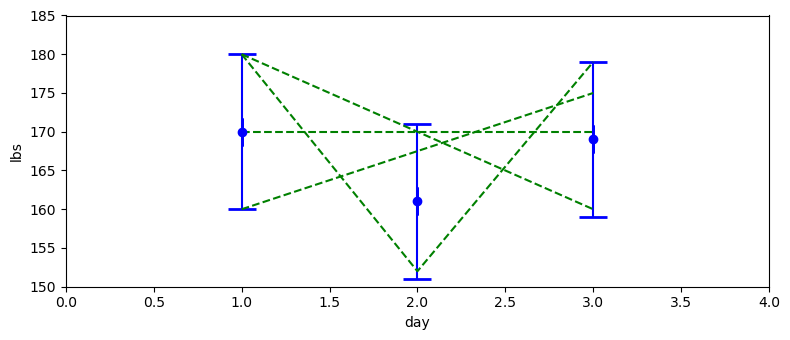

In [51]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

As we can see there is an extreme range of weight changes that could be explained by these three measurements. In fact, there are an infinite number of choices. Shall we give up? Not me! Recall that we are talking about measuring a human's weight. There is no reasonable way for a human to weigh 180 lbs on day 1 and 160 lbs on day 3. or to lose 30 lbs in one day only to gain it back the next (we will assume no amputations or other trauma has happened to the person). 

The behavior of the physical system we are measuring should influence how we interpret the measurements. If we were weighing a rock each day we'd attribute all of the variance to noise. If we were weighing a cistern fed by rain and used for household chores we might believe such weight changes are real.
 
Suppose I take a different scale, and I get the following measurements: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170. What does your intuition tell you? It is possible, for example, that you gained 1 lb each day, and the noisy measurements just happens to look like you stayed the same weight. Equally, you could have lost 1 lb a day and gotten the same readings. But is that likely? How likely is it to flip a coin and get 10 heads in a row? Not very likely. We can't prove it based solely on these readings, but it seems pretty likely that my weight held steady. In the chart below I've plotted the measurements with error bars, and a likely true weight in dashed green. This dashed line is not meant to be the 'correct' answer to this problem, merely one that is reasonable and could be explained by the measurement.

Как мы видим, существует экстремальный диапазон изменений веса, которые можно объяснить этими тремя измерениями. На самом деле, существует бесконечное количество вариантов. Сдадимся? Не я! Вспомните, что мы говорим об измерении веса человека. Не существует разумного способа для человека весить 180 фунтов в первый день и 160 фунтов в третий день или потерять 30 фунтов за один день, а затем снова набрать их на следующий (предположим, что у человека не было ампутаций или других травм).

Поведение измеряемой нами физической системы должно влиять на то, как мы интерпретируем измерения. Если бы мы взвешивали камень каждый день, мы бы приписали все отклонения шуму. Если бы мы взвешивали цистерну, наполненную дождем и используемую для домашних дел, мы могли бы поверить, что такие изменения веса реальны.

Предположим, я беру другие весы и получаю следующие измерения: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170. Что подсказывает вам ваша интуиция? Возможно, например, что вы набирали по 1 фунту каждый день, а шумные измерения просто выглядят так, будто вы остались в том же весе. Точно так же вы могли бы сбросить по 1 фунту в день и получить те же показания. Но насколько это вероятно? Насколько вероятно, что подбросите монетку и получите 10 орлов подряд? Не очень вероятно. Мы не можем доказать это, основываясь только на этих показаниях, но кажется довольно вероятным, что мой вес оставался стабильным. На диаграмме ниже я нанес измерения с погрешностями и вероятный истинный вес пунктирной зеленой линией. Эта пунктирная линия не должна быть «правильным» ответом на эту задачу, а просто тем, который является разумным и может быть объяснен измерением.

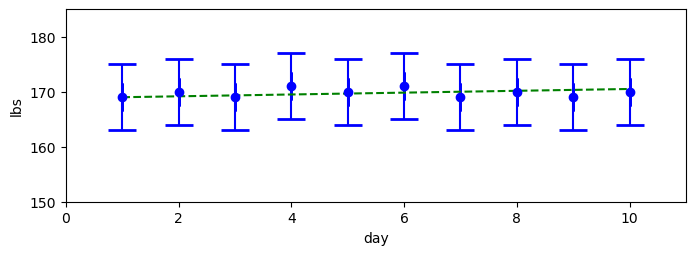

In [52]:
gh.plot_hypothesis2()

Another what if: what if the readings were 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? Let's look at a chart of that and then answer some questions.

Еще один вопрос: что если показания будут 158,0, 164,2, 160,3, 159,9, 162,1, 164,6, 169,6, 167,4, 166,4, 171,0? Давайте посмотрим на график, а затем ответим на несколько вопросов.

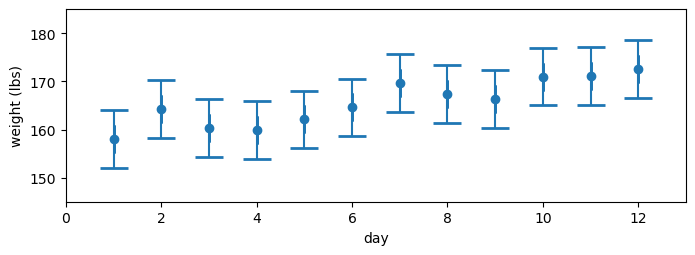

In [53]:
gh.plot_hypothesis3()

Does it 'seem' likely that I lost weight and this is just really noisy data? Not really. Does it seem likely that I held the same weight? Again, no. This data trends upwards over time; not evenly, but definitely upwards. We can't be sure, but that looks like a weight gain, and a significant weight gain at that. Let's test this assumption with some more plots. It is often easier to 'eyeball' data in a chart versus a table.

So let's look at two hypotheses. First, let's assume our weight did not change. To get that number we agreed that we should average the measurements. Let's look at that.

Кажется ли «вероятным», что я похудел, и это просто очень шумные данные? Не совсем. Кажется ли вероятным, что я сохранил тот же вес? Опять же, нет. Эти данные имеют тенденцию к росту с течением времени; не равномерно, но определенно растут. Мы не можем быть уверены, но это похоже на набор веса, и притом значительный набор веса. Давайте проверим это предположение с помощью еще нескольких графиков. Часто проще «на глаз» оценить данные в диаграмме, чем в таблице.

Итак, давайте рассмотрим две гипотезы. Во-первых, давайте предположим, что наш вес не изменился. Чтобы получить это число, мы договорились, что должны усреднить измерения. Давайте рассмотрим это.

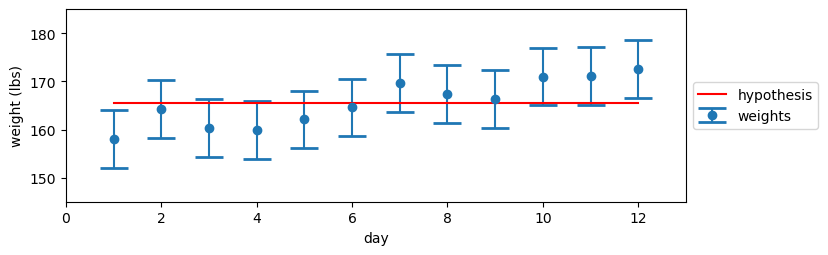

In [54]:
gh.plot_hypothesis4()

That doesn't look very convincing. In fact, we can see that there is no horizontal line that we could draw that is inside all of the error bars.

Now, let's assume we gained weight. How much? I don't know, but NumPy does! We want to draw a line through the measurements that looks 'about' right. NumPy has functions that will do this according to a rule called "least squares fit". Let's not worry about the details of that computation (I use [polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) if you are interested), and just plot the results.

Это выглядит не очень убедительно. На самом деле, мы видим, что нет горизонтальной линии, которую мы могли бы нарисовать внутри всех планок погрешности.

Теперь предположим, что мы набрали вес. Насколько? Я не знаю, но NumPy знает! Мы хотим провести линию через измерения, которая выглядит «примерно» правильно. В NumPy есть функции, которые сделают это в соответствии с правилом, называемым «наименьшими квадратами». Давайте не будем беспокоиться о деталях этого вычисления (я использую [polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), если вам интересно), и просто отобразим результаты.

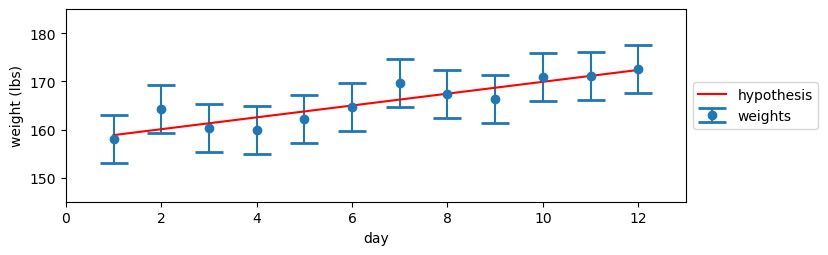

In [55]:
gh.plot_hypothesis5()

This looks much better, at least to my eyes. Notice now the hypothesis lies very close to each measurement, whereas in the previous plot the hypothesis was often quite far from the measurement. It seems far more likely to be true that I gained weight than I didn't gain any weight. Did I actually gain 13 lbs? Who can say? That seems impossible to answer.

"But is it impossible?" pipes up a co-worker.

Let's try something crazy. Let's assume that I know I am gaining about one lb a day. It doesn't matter how I know that right now, assume I know it is approximately correct. Maybe I am on a 6000 calorie a day diet, which would result in such a weight gain. Or maybe there is another way to estimate the weight gain. This is a thought experiment, the details are not important. Let's see if we can make use of such information if it was available.

The first measurement was 158. We have no way of knowing any different, so let's accept that as our estimate. If our weight today is 158, what will it be tomorrow? Well, we think we are gaining weight at 1 lb/day, so our prediction is 159, like so:

Это выглядит намного лучше, по крайней мере, на мой взгляд. Обратите внимание, что теперь гипотеза лежит очень близко к каждому измерению, тогда как на предыдущем графике гипотеза часто была довольно далека от измерения. Кажется, гораздо более вероятно, что я набрал вес, чем не набрал вообще. На самом ли деле я набрал 13 фунтов? Кто может сказать? На это, кажется, невозможно ответить.

«Но разве это невозможно?» — встревает коллега.

Давайте попробуем что-нибудь безумное. Предположим, что я знаю, что набираю около одного фунта в день. Неважно, откуда я это знаю прямо сейчас, предположим, что я знаю, что это приблизительно правильно. Может быть, я на диете в 6000 калорий в день, что привело бы к такому набору веса. Или, может быть, есть другой способ оценить набор веса. Это мысленный эксперимент, детали не важны. Давайте посмотрим, сможем ли мы использовать такую ​​информацию, если она будет доступна.

Первое измерение было 158. У нас нет возможности узнать что-то другое, поэтому давайте примем это как нашу оценку. Если наш вес сегодня 158, сколько будет завтра? Ну, мы думаем, что набираем вес по 1 фунту в день, поэтому наш прогноз 159, вот так:

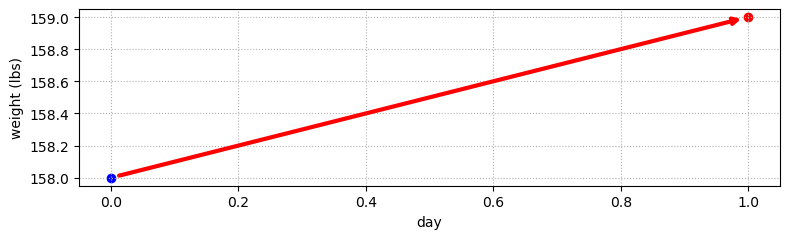

In [56]:
gh.plot_estimate_chart_1()

Okay, but what good is this? Sure, we could assume the 1 lb/day is accurate, and predict our weight for the next 10 days, but then why use a scale at all if we don't incorporate its readings? So let's look at the next measurement. We step on the scale again and it displays 164.2 lbs.

Хорошо, но что в этом хорошего? Конечно, мы могли бы предположить, что 1 фунт/день — это точно, и предсказать наш вес на следующие 10 дней, но тогда зачем вообще использовать весы, если мы не учитываем их показания? Итак, давайте посмотрим на следующее измерение. Мы снова встаем на весы, и они показывают 164,2 фунта.

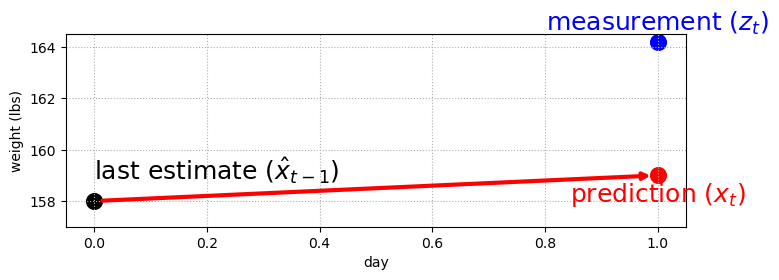

In [57]:
gh.plot_estimate_chart_2()

We have a problem. Our prediction doesn't match our measurement. But, that is what we expected, right? If the prediction was always exactly the same as the measurement, it would not be capable of adding any information to the filter. And, of course, there would be no reason to ever measure since our predictions are perfect.

> **The key insight to this entire book is in the next paragraph. Read it carefully!**

So what do we do? If we only form estimates from the measurement then the prediction will not affect the result. If we only form estimates from the prediction then the measurement will be ignored. If this is to work we need to take some kind of **blend of the prediction and measurement** (I've bolded the key point).

У нас проблема. Наше предсказание не соответствует нашему измерению. Но ведь именно этого мы и ожидали, верно? Если бы предсказание всегда было точно таким же, как и измерение, оно не смогло бы добавить никакой информации в фильтр. И, конечно, не было бы никаких причин когда-либо измерять, поскольку наши предсказания идеальны.

> **Ключевое понимание всей этой книги находится в следующем абзаце. Прочитайте его внимательно!**

Итак, что нам делать? Если мы только формируем оценки из измерения, то предсказание не повлияет на результат. Если мы только формируем оценки из предсказания, то измерение будет игнорироваться. Чтобы это сработало, нам нужно взять некую **смесь предсказания и измерения** (я выделил жирным ключевой момент).

Blending two values - this sounds a lot like the two scale problem earlier. Using the same reasoning as before we can see that the only thing that makes sense is to choose a number between the prediction and the measurement. For example, an estimate of 165 makes no sense, nor does 157. Our estimates should lie between 159 (the prediction) and 164.2 (the measurement).

One more time, this is so important. We agreed that when presented two values with errors, we should form an estimate part way between the two values. It does not matter how those values were generated. In the start of the chapter we had two measurements, but now we have one measurement and one prediction. The reasoning, and hence the math is the same in both cases. We *never* throw information away. I mean it. I see so much commercial software that throws away noisy data. Don't do it! Our prediction of a weight gain might not be very accurate, but so long as there is some information we should use it.

I have to insist you stop and really think about this. All I have done is replaced an inaccurate scale with an inaccurate weight prediction based on human physiology. It is still data. Math doesn't know if the data came from a scale or a prediction. We have two pieces of data with a certain amount of noise, and we want to combine them. In the remainder of this book we are going to develop some fairly complicated math to perform this computation, but the math never cares where the data come from, it only makes computations based on the value and accuracy of those values. 

Should the estimate be half way between the measurement and prediction? Maybe, but in general it seems like we might know that our prediction is more or less accurate compared to the measurements. Probably the accuracy of our prediction differs from the accuracy of the scale. Recall what we did when scale A was much more accurate than scale B - we scaled the answer to be closer to A than B. Let's look at that in a chart.

Смешивание двух значений — это очень похоже на проблему двух шкал ранее. Используя те же рассуждения, что и раньше, мы можем увидеть, что единственное, что имеет смысл, — это выбрать число между прогнозом и измерением. Например, оценка 165 не имеет смысла, как и 157. Наши оценки должны лежать между 159 (прогноз) и 164,2 (измерение).

Еще раз, это очень важно. Мы договорились, что при представлении двух значений с ошибками мы должны сформировать оценку на полпути между двумя значениями. Неважно, как были получены эти значения. В начале главы у нас было два измерения, но теперь у нас одно измерение и одно предсказание. Рассуждения, а следовательно, и математика одинаковы в обоих случаях. Мы *никогда* не выбрасываем информацию. Я серьезно. Я вижу так много коммерческого программного обеспечения, которое выбрасывает шумные данные. Не делайте этого! Наш прогноз набора веса может быть не очень точным, но пока есть какая-то информация, мы должны ее использовать.

Я должен настаивать, чтобы вы остановились и действительно задумались об этом. Все, что я сделал, это заменил неточные весы на неточный прогноз веса, основанный на физиологии человека. Это все еще данные. Математика не знает, были ли данные получены с весов или из прогноза. У нас есть два фрагмента данных с определенным количеством шума, и мы хотим их объединить. В оставшейся части этой книги мы разработаем довольно сложную математику для выполнения этого вычисления, но математике все равно, откуда берутся данные, она только производит вычисления, основанные на значении и точности этих значений.

Должна ли оценка быть на полпути между измерением и прогнозом? Возможно, но в целом кажется, что мы можем знать, что наш прогноз более или менее точен по сравнению с измерениями. Вероятно, точность нашего прогноза отличается от точности весов. Вспомните, что мы делали, когда шкала A была намного точнее шкалы B — мы масштабировали ответ так, чтобы он был ближе к A, чем к B. Давайте посмотрим на это в таблице.

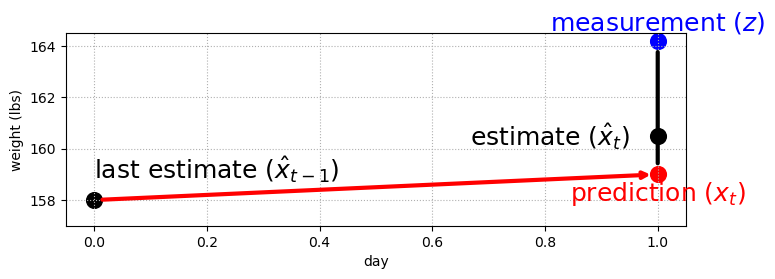

In [58]:
gh.plot_estimate_chart_3()

Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a belief here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

The difference between the measurement and prediction is called the *residual*, which is depicted by the black vertical line in the plot above. This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output. Smaller residuals imply better performance.

Let's code that and see the results when we test it against the series of weights from above. We have to take into account one other factor. Weight gain has units of lbs/time, so to be general we will need to add a time step $t$, which we will set to 1 (day). 

I hand generated the weight data to correspond to a true starting weight of 160 lbs, and a weight gain of 1 lb per day. In other words on the first day (day zero) the true weight is 160lbs, on the second day (day one, the first day of weighing) the true weight is 161 lbs, and so on. 

We need to make a guess for the initial weight. It is too early to talk about initialization strategies, so for now I will assume 160 lbs.

Теперь давайте попробуем случайно выбранное число для масштабирования нашей оценки: $\frac{4}{10}$. Наша оценка будет составлять четыре десятых измерения, а остальное будет из прогноза. Другими словами, мы выражаем здесь убеждение, убеждение, что прогноз с большей вероятностью будет правильным, чем измерение. Мы вычисляем это как

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

Разница между измерением и прогнозом называется *остатком*, который изображен черной вертикальной линией на графике выше. Это станет важным значением для использования позже, поскольку это точное вычисление разницы между измерениями и выходными данными фильтра. Меньшие остатки подразумевают лучшую производительность.

Давайте закодируем это и посмотрим на результаты, когда мы протестируем его против ряда весов сверху. Мы должны принять во внимание еще один фактор. Единицей измерения набора веса является фунт/время, поэтому для обобщения нам нужно будет добавить временной шаг $t$, который мы установим на 1 (день).

Я вручную сгенерировал данные о весе, чтобы они соответствовали истинному начальному весу 160 фунтов и прибавке веса 1 фунт в день. Другими словами, в первый день (нулевой день) истинный вес составляет 160 фунтов, во второй день (первый день, первый день взвешивания) истинный вес составляет 161 фунт и так далее.

Нам нужно сделать предположение о начальном весе. Пока слишком рано говорить о стратегиях инициализации, поэтому пока я предположу 160 фунтов.

In [59]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # day
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


[158.0,
 164.2,
 160.3,
 159.9,
 162.1,
 164.6,
 169.6,
 167.4,
 166.4,
 171.0,
 171.2,
 172.6]

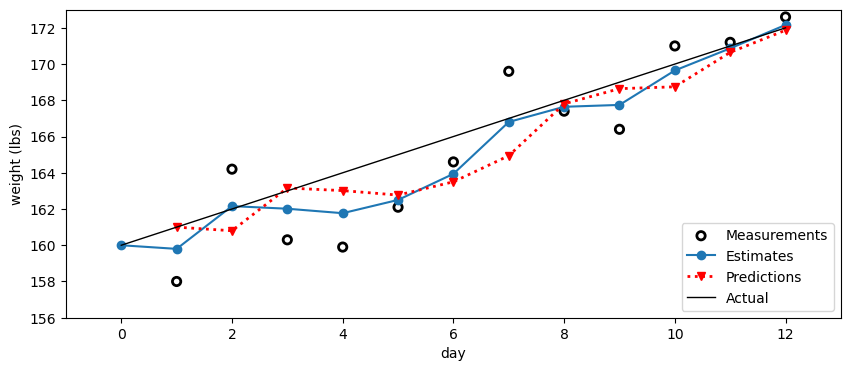

In [60]:
# plot results
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 172])
weights

That is pretty good! There is a lot of data here, so let's talk about how to interpret it.  The thick blue line shows the estimate from the filter. It starts at day 0 with the initial guess of 160 lbs. The red line shows the prediction that is made from the previous day's weight. So, on day one the previous weight was 160 lbs, the weight gain is 1 lb, and so the first prediction is 161 lbs. The estimate on day one is then part way between the prediction and measurement at 159.8 lbs. Below the chart is a print out of the previous weight, predicted weight, and new estimate for each day. Finally, the thin black line shows the actual weight gain of the person being weighed.

Walk through this for each day, ensuring you understand how the prediction and estimates were formed at each step. Note how the estimate always falls between the measurement and prediction.

The estimates are not a straight line, but they are straighter than the measurements and somewhat close to the trend line we created. Also, it seems to get better over time.

The results of the filter may strike you as quite silly; of course the data will look good if we assume the conclusion, that our weight gain is around 1 lb/day! Let's see what the filter does if our initial guess is bad. Let's predict that there is a weight loss of 1 lb a day:

Это довольно хорошо! Здесь много данных, поэтому давайте поговорим о том, как их интерпретировать. Толстая синяя линия показывает оценку из фильтра. Она начинается в день 0 с начальной догадкой в ​​160 фунтов. Красная линия показывает прогноз, сделанный на основе веса предыдущего дня. Итак, в первый день предыдущий вес был 160 фунтов, прибавка в весе составляет 1 фунт, и поэтому первый прогноз составляет 161 фунт. Оценка в первый день находится на полпути между прогнозом и измерением и составляет 159,8 фунтов. Под диаграммой находится распечатка предыдущего веса, прогнозируемого веса и новой оценки для каждого дня. Наконец, тонкая черная линия показывает фактическую прибавку в весе человека, которого взвешивают.

Пройдитесь по этому для каждого дня, убедившись, что вы понимаете, как были сформированы прогноз и оценки на каждом этапе. Обратите внимание, что оценка всегда находится между измерением и прогнозом.

Оценки не являются прямой линией, но они прямее измерений и несколько близки к созданной нами линии тренда. Кроме того, со временем, кажется, становится лучше.

Результаты фильтра могут показаться вам довольно глупыми; конечно, данные будут выглядеть хорошо, если мы предположим вывод, что наш набор веса составляет около 1 фунта/день! Давайте посмотрим, что сделает фильтр, если наша первоначальная догадка плоха. Давайте предскажем, что потеря веса составит 1 фунт в день:

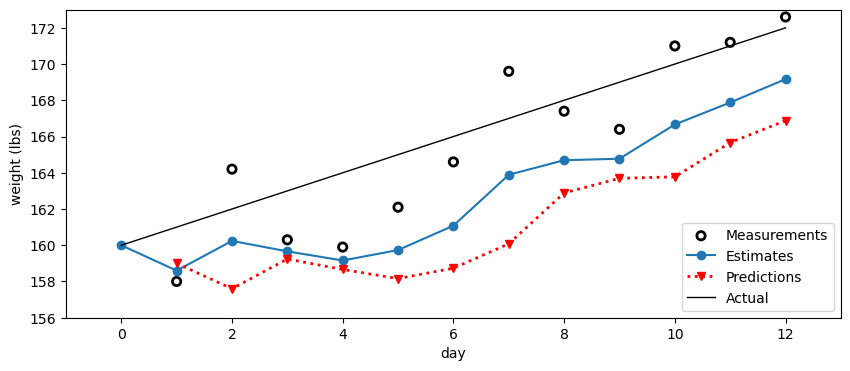

In [61]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 172])

That is not so impressive. The estimates quickly divert from the measurements. Clearly a filter that requires us to correctly guess a rate of change is not very useful. Even if our initial guess was correct, the filter will fail as soon as that rate of change changes. If I stop overeating the filter will have extreme difficulty in adjusting to that change. Note that it is adjusting! The estimates are climbing even though we tell it we are losing 1 lb a day. It just can't adjust fast enough.

But, 'what if'? What if instead of leaving the weight gain at the initial guess of 1 lb (or whatever), we compute it from the existing measurements and estimates. On day one our estimate for the weight is:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

On the next day we measure 164.2, which implies a weight gain of 4.4 lbs (since 164.2 - 159.8 = 4.4), not 1. Can we use this information somehow? It seems plausible. After all, the weight measurement itself is based on a real world measurement of our weight, so there is useful information. Our estimate of our weight gain may not be perfect, but it is surely better than just guessing our gain is 1 lb. Data is better than a guess, even if it is noisy.

People really balk at this point, so make sure you are in agreement. Two noisy measurements of weight give us an implied weight gain/loss. That estimate is going to be very inaccurate if the measurements are inaccurate, but there is still information in this computation. Imagine weighing a cow with a scale accurate to 1 lb, and it shows that the cow gained 10 lbs. The cow might have gained 8 lbs up to 12 lbs, depending on the errors, but we know it gained weight, and roughly how much. This is information. What do we do with information? Never throw it away!

Back to my diet. Should we set the new gain/day to 4.4 lbs? Yesterday we thought the weight gain was 1 lb, today we think it is 4.4 lbs. We have two numbers, and want to combine them somehow. Hmm, sounds like our same problem again. Let's use our same tool, and the only tool we have so far - pick a value part way between the two. This time I will use another arbitrarily chosen number, $\frac{1}{3}$. The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day):

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$0

Это не так уж и впечатляет. Оценки быстро отклоняются от измерений. Очевидно, что фильтр, который требует от нас правильно угадать скорость изменения, не очень полезен. Даже если наша первоначальная догадка была правильной, фильтр выйдет из строя, как только эта скорость изменения изменится. Если я перестану переедать, фильтру будет крайне сложно приспособиться к этому изменению. Обратите внимание, что он приспосабливается! Оценки растут, хотя мы говорим ему, что теряем 1 фунт в день. Он просто не может приспособиться достаточно быстро.

Но «что если»? Что если вместо того, чтобы оставить прибавку в весе на первоначальной догадке в 1 фунт (или сколько угодно), мы вычислим ее на основе существующих измерений и оценок. В первый день наша оценка веса:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159,8
$$

На следующий день мы измеряем 164,2, что подразумевает прибавку в весе 4,4 фунта (так как 164,2 - 159,8 = 4,4), а не 1. Можем ли мы как-то использовать эту информацию? Это кажется правдоподобным. В конце концов, само измерение веса основано на реальном измерении нашего веса, поэтому есть полезная информация. Наша оценка нашего набора веса может быть не идеальной, но это, безусловно, лучше, чем просто предположить, что наш набор составляет 1 фунт. Данные лучше, чем предположение, даже если они шумные.

Люди действительно упираются в этот момент, поэтому убедитесь, что вы согласны. Два шумных измерения веса дают нам подразумеваемый набор/потерю веса. Эта оценка будет очень неточной, если измерения неточны, но в этом вычислении все еще есть информация. Представьте, что вы взвешиваете корову на весах с точностью до 1 фунта, и они показывают, что корова набрала 10 фунтов. Корова могла набрать от 8 до 12 фунтов, в зависимости от погрешности, но мы знаем, что она набрала вес и примерно на сколько. Это информация. Что мы делаем с информацией? Никогда не выбрасываем ее!

Вернемся к моей диете. Стоит ли нам установить новый прирост/день на 4,4 фунта? Вчера мы думали, что прирост веса составил 1 фунт, сегодня мы думаем, что это 4,4 фунта. У нас есть два числа, и мы хотим как-то их объединить. Хм, похоже, снова та же проблема. Давайте воспользуемся нашим тем же инструментом, и единственным инструментом, который у нас есть на данный момент, — выберем значение, находящееся посередине между ними. На этот раз я буду использовать другое произвольно выбранное число, $\frac{1}{3}$. Уравнение идентично уравнению для оценки веса, за исключением того, что нам нужно включить время, поскольку это скорость (прирост/день):

$$\text{новый прирост} = \text{старый прирост} + \frac{1}{3}\frac{\text{измерение - прогнозируемый вес}}{1 \text{день}}
$$

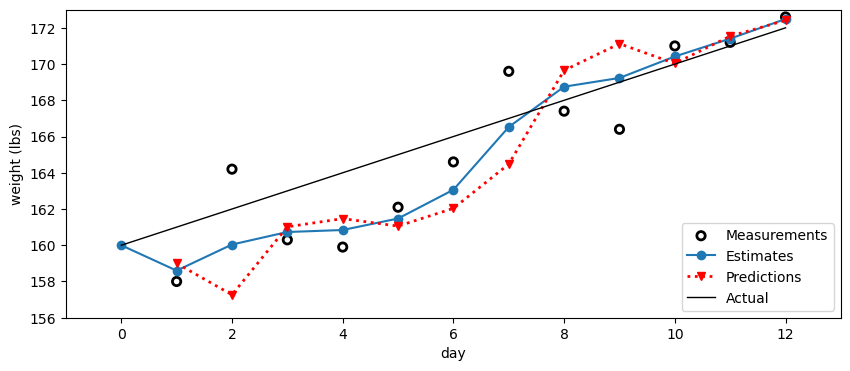

In [62]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # prediction step
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # update step    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 172])

I think this is starting to look really good. Because of the poor initial guess of the weight gain being -1 it takes the filter several days to accurately predict the weight, but once it does that it starts to accurately track the weight. We used no methodology for choosing our scaling factors of $\frac{4}{10}$ and $\frac{1}{3}$ (actually, they are poor choices for this problem), but otherwise all of the math followed from very reasonable assumptions. Recall that you can change the value of the parameter `time_step` to a larger value and re-run the cell if you want to see the plot drawn step-by-step.

One final point before we go on. In the prediction step I wrote the line
```python
gain_rate = gain_rate
``` 
This obviously has no effect, and can be removed. I wrote this to emphasize that in the prediction step you need to predict the next value for all variables, both `weight` and `gain_rate`. This will become relevant shortly. In this case we are assuming that the gain does not vary, but when we generalize this algorithm we will remove that assumption. 

Я думаю, это начинает выглядеть действительно хорошо. Из-за плохого начального предположения о приросте веса, равном -1, фильтру требуется несколько дней, чтобы точно предсказать вес, но как только он это сделает, он начнет точно отслеживать вес. Мы не использовали никакой методологии для выбора наших масштабных коэффициентов $\frac{4}{10}$ и $\frac{1}{3}$ (на самом деле, они являются плохим выбором для этой задачи), но в остальном вся математика следовала из очень разумных предположений. Вспомните, что вы можете изменить значение параметра `time_step` на большее значение и перезапустить ячейку, если хотите увидеть график, нарисованный шаг за шагом. 

Последний момент, прежде чем мы продолжим. На этапе прогнозирования я написал строку 

```python 
gain_rate = gain_rate 
``` 

Очевидно, что это не имеет никакого эффекта и может быть удалено. 

Я написал это, чтобы подчеркнуть, что на этапе прогнозирования вам нужно предсказать следующее значение для всех переменных, как `weight`, так и `gain_rate`. Это станет актуальным вскоре. В этом случае мы предполагаем, что коэффициент усиления не меняется, но при обобщении этого алгоритма мы удалим это предположение.

## The g-h Filter

This algorithm is known as the [g-h filter](https://en.wikipedia.org/wiki/Alpha_beta_filter) or the $\alpha$-$\beta$ filter. $g$ and $h$ refer to the two scaling factors that we used in our example. $g$ is the scaling we used for the measurement (weight in our example), and $h$ is the scaling for the change in measurement over time (lbs/day in our example). $\alpha$ and $\beta$ are just different names used for this factors.

Этот алгоритм известен как [фильтр g-h](https://en.wikipedia.org/wiki/Alpha_beta_filter) или фильтр $\alpha$-$\beta$. $g$ и $h$ относятся к двум масштабным коэффициентам, которые мы использовали в нашем примере. $g$ — это масштаб, который мы использовали для измерения (вес в нашем примере), а $h$ — это масштаб для изменения измерения с течением времени (фунты/день в нашем примере). $\alpha$ и $\beta$ — это просто разные названия, используемые для этих коэффициентов.

This filter is the basis for a huge number of filters, including the Kalman filter. In other words, the Kalman filter is a form of the g-h filter, which I will prove later in the book. So is the Least Squares filter, which you may have heard of, and so is the Benedict-Bordner filter, which you probably have not. Each filter has a different way of assigning values to $g$ and $h$, but otherwise the algorithms are identical. For example, the Benedict-Bordner filter assigns a constant to $g$ and $h$, constrained to a certain range of values. Other filters such as the Kalman will vary $g$ and $h$ dynamically at each time step.

**Let me repeat the key points as they are so important**. If you do not understand these you will not understand the rest of the book. If you do understand them, then the rest of the book will unfold naturally for you as mathematical elaborations to various 'what if' questions we will ask about $g$ and $h$. The math may look profoundly different, but the algorithm will be exactly the same.

* Multiple data points are more accurate than one data point, so throw nothing away no matter how inaccurate it is.
* Always choose a number part way between two data points to create a more accurate estimate.
* Predict the next measurement and rate of change based on the current estimate and how much we think it will change.
* The new estimate is then chosen as part way between the prediction and next measurement scaled by how accurate each is.

Let's look at a visual depiction of the algorithm.

Этот фильтр является основой для огромного количества фильтров, включая фильтр Калмана. Другими словами, фильтр Калмана является формой фильтра g-h, что я докажу позже в этой книге. То же самое относится к фильтру наименьших квадратов, о котором вы, возможно, слышали, и к фильтру Бенедикта-Борднера, о котором вы, вероятно, не слышали. Каждый фильтр имеет свой способ присвоения значений $g$ и $h$, но в остальном алгоритмы идентичны. Например, фильтр Бенедикта-Борднера присваивает константу $g$ и $h$, ограниченную определенным диапазоном значений. Другие фильтры, такие как фильтр Калмана, будут динамически изменять $g$ и $h$ на каждом временном шаге.

**Позвольте мне повторить ключевые моменты, поскольку они очень важны**. Если вы их не поймете, вы не поймете и остальную часть книги. Если вы их понимаете, то остальная часть книги будет естественным образом разворачиваться для вас как математические разработки различных вопросов «что если», которые мы зададим о $g$ и $h$. Математика может выглядеть совершенно иначе, но алгоритм будет точно таким же.

* Несколько точек данных точнее, чем одна точка данных, поэтому не отбрасывайте ничего, независимо от того, насколько это неточно.
* Всегда выбирайте число посередине между двумя точками данных, чтобы создать более точную оценку.
* Прогнозируйте следующее измерение и скорость изменения на основе текущей оценки и того, насколько, по нашему мнению, оно изменится.
* Затем новая оценка выбирается посередине между прогнозом и следующим измерением, масштабированным по точности каждого из них.

Давайте рассмотрим визуальное изображение алгоритма.

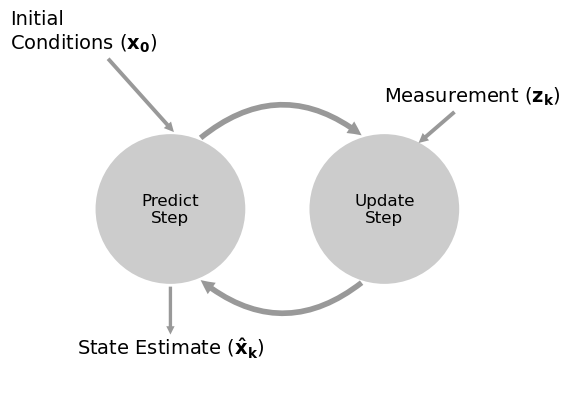

In [20]:
book_plots.predict_update_chart()

Let me introduce some more formal terminology. The *system* is the object that we want to estimate. In this chapter the system is whatever we are trying to weigh. Some texts call this the *plant*. That terminology comes from control system theory. https://en.wikipedia.org/wiki/Plant_(control_theory)

The *state* of the system is the current configuration or values of that system that is of interest to us. We are interested only in the weight reading. If I put a 100 kg weight on the scale, the state is 100kg. We define the state based on what is relevant to us. The color of the scale is irrelevant to us so we do not include those values in the state. A QA engineer for the manufacturer might include color in the state so that she can track and control the manufacturing process. 

The *measurement* is a measured value of the system. Measurements can be inaccurate, so it may not have the same value as the state.

The *state estimate* is our filter's estimate of the state. For example, for the 100 kg weight our estimate might be 99.327 kg due to sensor errors. This is commonly abbreviated to *estimate*, and I have done that in this chapter.

In other words, the state should be understood as the actual value of the system. This value is usually *hidden* to us.  If I stepped on a scale you'd then have a *measurement*. We call this *observable* since you can directly observe this measurement. In contrast, you can never directly observe my weight, you can only measure it. 

This language of *hidden* and *observable* is important. Any estimation problem consists of forming an estimate of a hidden state via observable measurements. If you read the literature these terms are used when defining a problem, so you need to be comfortable with them.

We use a *process model* to mathematically model the system. In this chapter our process model is the assumption that my weight today is yesterday's weight plus my weight gain for the last day. The process model does not model or otherwise account for the sensors. Another example would be a process model for an automobile. The process model might be "distance equals velocity times time. This model is not perfect as the velocity of a car can vary over a non-zero amount of time, the tires can slip on the road, and so on. The *system error* or *process error* is the error in this model. We never know this value exactly; if we did we could refine our model to have zero error. Some texts use *plant model* and *plant error*. You may also see *system model*. They all mean the same thing.

The predict step is known as *system propagation*. It uses the *process model* to form a new *state estimate*. Because of the *process error* this estimate is imperfect. Assuming we are tracking data over time, we say we *propagate* the state into the future. Some texts call this the *evolution*. 

The update step is known as the *measurement update*. One iteration of the system propagation and measurement update is known as an *epoch*. 

Now let's explore a few different problem domains to better understand this algorithm. Consider the problem of trying to track a train on a track. The track constrains the position of the train to a very specific region. Furthermore, trains are large and slow. It takes many minutes for them to slow down or speed up significantly. So, if I know that the train is at kilometer marker 23 km at time t and moving at 18 kph, I can be extremely confident in predicting its position at time t + 1 second. Why is that important? Suppose we can only measure its position with an accuracy of $\pm$ 250 meters. The train is moving at 18 kph, which is 5 meters per second. At t+1 seconds the train will be at 23.005 km yet the measurement could be anywhere from 22.755 km to 23.255 km. So if the next measurement says the position is at 23.4 we know that must be inaccurate. Even if at time t the engineer slammed on the brakes the train will still be very near to 23.005 km because a train cannot slow down very much in 1 second. If we were to design a filter for this problem (and we will a bit further in the chapter!) we would want to design a filter that gave a very high weighting to the prediction vs the measurement. 

Позвольте мне ввести более формальную терминологию. *Система* — это объект, который мы хотим оценить. В этой главе система — это то, что мы пытаемся взвесить. В некоторых текстах это называется *завод*. Этот термин взят из теории систем управления. https://en.wikipedia.org/wiki/Plant_(control_theory)

*Состояние* системы — это текущая конфигурация или значения этой системы, которые нас интересуют. Нас интересуют только показания веса. Если я положу на весы вес 100 кг, состояние будет 100 кг. Мы определяем состояние на основе того, что для нас важно. Цвет весов не важен для нас, поэтому мы не включаем эти значения в состояние. Инженер по контролю качества для производителя может включить цвет в состояние, чтобы отслеживать и контролировать производственный процесс.

*Измерение* — это измеренное значение системы. Измерения могут быть неточными, поэтому они могут не совпадать со значением состояния.

*Оценка состояния* — это оценка состояния нашим фильтром. Например, для веса 100 кг наша оценка может быть 99,327 кг из-за ошибок датчика. Обычно это сокращается до *оценки*, и я сделал это в этой главе.

Другими словами, состояние следует понимать как фактическое значение системы. Это значение обычно *скрыто* для нас. Если бы я встал на весы, то у вас было бы *измерение*. Мы называем это *наблюдаемым*, поскольку вы можете непосредственно наблюдать это измерение. Напротив, вы никогда не можете непосредственно наблюдать мой вес, вы можете только измерить его.

Этот язык *скрытого* и *наблюдаемого* важен. Любая задача оценки состоит в формировании оценки скрытого состояния с помощью наблюдаемых измерений. Если вы читали литературу, эти термины используются при определении проблемы, поэтому вам нужно быть с ними знакомыми.

Мы используем *модель процесса* для математического моделирования системы. В этой главе наша модель процесса основана на предположении, что мой сегодняшний вес — это вчерашний вес плюс мой прирост веса за последний день. Модель процесса не моделирует и не учитывает каким-либо иным образом датчики. Другим примером может служить модель процесса для автомобиля. Модель процесса может быть «расстояние равно скорости, умноженной на время». Эта модель не идеальна, поскольку скорость автомобиля может меняться в течение ненулевого периода времени, шины могут скользить по дороге и т. д. *Ошибка системы* или *ошибка процесса* — это ошибка в этой модели. Мы никогда не знаем этого значения точно; если бы мы знали, мы могли бы усовершенствовать нашу модель, чтобы иметь нулевую ошибку. В некоторых текстах используются *модель установки* и *ошибка установки*. Вы также можете увидеть *модель системы*. Все они означают одно и то же.

Этап прогнозирования известен как *распространение системы*. Он использует *модель процесса* для формирования новой *оценки состояния*. Из-за *ошибки процесса* эта оценка несовершенна. Предполагая, что мы отслеживаем данные с течением времени, мы говорим, что мы *распространяем* состояние в будущее. В некоторых текстах это называется *эволюцией*.

Этап обновления известен как *обновление измерения*. Одна итерация распространения системы и обновления измерения известна как *эпоха*.

Теперь давайте Исследуйте несколько различных проблемных областей, чтобы лучше понять этот алгоритм. Рассмотрим задачу отслеживания поезда на рельсах. Рельсы ограничивают положение поезда очень конкретной областью. Кроме того, поезда большие и медленные. Им требуется много минут, чтобы значительно замедлиться или ускориться. Итак, если я знаю, что поезд находится на отметке километра 23 км в момент времени t и движется со скоростью 18 км/ч, я могу быть очень уверен в предсказании его положения в момент времени t + 1 секунда. Почему это важно? Предположим, мы можем измерить его положение с точностью только $\pm$ 250 метров. Поезд движется со скоростью 18 км/ч, что составляет 5 метров в секунду. В момент t + 1 секунда поезд будет на расстоянии 23,005 км, хотя измерение может быть где угодно от 22,755 км до 23,255 км. Поэтому, если следующее измерение покажет, что положение находится на 23,4, мы знаем, что это должно быть неточным. Даже если в момент времени t машинист нажал на тормоза, поезд все равно будет очень близок к 23,005 км, потому что поезд не может сильно замедлиться за 1 секунду. Если бы мы разрабатывали фильтр для этой проблемы (и мы сделаем это немного дальше в этой главе!), мы бы хотели разработать фильтр, который давал бы очень высокий вес прогнозу по сравнению с измерением.

Now consider the problem of tracking a thrown ball. We know that a ballistic object moves in a parabola in a vacuum when in a gravitational field. But a ball thrown on Earth is influenced by air drag, so it does not travel in a perfect parabola. Baseball pitchers take advantage of this fact when they throw curve balls. Let's say that we are tracking the ball inside a stadium using computer vision, something I do at work. The accuracy of the computer vision tracking might be modest, but predicting the ball's future positions by assuming that it is moving on a parabola is not extremely accurate either. In this case we'd probably design a filter that gave roughly equal weight to the measurement and the prediction.

Now consider trying to track a helium party balloon in a hurricane. We have no legitimate model that would allow us to predict the balloon's behavior except over very brief time scales (we know the balloon cannot go 10 miles in 1 second, for example). In this case we would design a filter that emphasized the measurements over the predictions.

Most of this book is devoted to expressing the concerns in the last three paragraphs mathematically, which then allows us to find an optimal solution (in some mathematical sense). In this chapter we will merely be assigning different values to $g$ and $h$ in a more intuitive, and thus less optimal way. But the fundamental idea is to blend somewhat inaccurate measurements with somewhat inaccurate models of how the systems behaves to get a filtered estimate that is better than either information source by itself.

We can express this as an algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state

**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. New estimate is somewhere on the residual line
    
We will use this same algorithm throughout the book, albeit with some modifications. 

Теперь рассмотрим задачу отслеживания брошенного мяча. Мы знаем, что баллистический объект движется по параболе в вакууме, находясь в гравитационном поле. Но мяч, брошенный на Земле, находится под влиянием сопротивления воздуха, поэтому он не движется по идеальной параболе. Бейсбольные питчеры пользуются этим фактом, когда бросают крученые мячи. Допустим, мы отслеживаем мяч на стадионе с помощью компьютерного зрения, чем я занимаюсь на работе. Точность отслеживания компьютерного зрения может быть скромной, но предсказание будущих положений мяча, предполагая, что он движется по параболе, также не является чрезвычайно точным. В этом случае мы, вероятно, разработали бы фильтр, который придал бы примерно равный вес измерению и прогнозу.

Теперь рассмотрим попытку отслеживания воздушного шара для вечеринки с гелием во время урагана. У нас нет законной модели, которая позволила бы нам предсказать поведение воздушного шара, за исключением очень коротких временных масштабов (например, мы знаем, что воздушный шар не может пролететь 10 миль за 1 секунду). В этом случае мы разработали бы фильтр, который бы подчеркивал измерения, а не прогнозы.

Большая часть этой книги посвящена выражению проблем в последних трех абзацах математически, что затем позволяет нам найти оптимальное решение (в некотором математическом смысле). В этой главе мы просто будем присваивать различные значения $g$ и $h$ более интуитивным и, следовательно, менее оптимальным способом. Но основная идея заключается в том, чтобы смешать несколько неточные измерения с несколько неточными моделями поведения систем, чтобы получить отфильтрованную оценку, которая лучше, чем любой источник информации по отдельности.

Мы можем выразить это в виде алгоритма:

**Инициализация**

1. Инициализируем состояние фильтра

2. Инициализируем наше убеждение в состоянии

**Прогноз**

1. Используем поведение системы для прогнозирования состояния на следующем временном шаге

2. Скорректируем убеждение для учета неопределенности в прогнозе

**Обновление**

1. Получаем измерение и связанное с ним убеждение о его точности

2. Вычисляем остаток между оценочным состоянием и измерением

3. Новая оценка находится где-то на линии остатка

Мы будем использовать этот же алгоритм на протяжении всей книги, хотя и с некоторыми изменениями.

## Notation

I'll begin to introduce the notations and variable names used in the literature. Some of this was already used in the above charts. Measurement is typically denoted $z$ and that is what we will use in this book (some literature uses $y$). Subscript $k$ indicates the time step, so $z_k$ is the data for this time step. A bold font denotes a vector or matrix. So far we have only considered having one sensor, and hence one sensor measurement, but in general we may have *n* sensors and *n* measurements. $\mathbf{x}$ denotes our state, and is bold to denote that it is a vector. For our scale example, it represents both the initial weight and initial weight gain rate, like so:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

Here I use Newton's notation of a dot over the x to denote velocity. More precisely, the dot implies the derivative of x with respect to time, which of course is the velocity. For a weight of 62 kg with a gain of 0.3 kg/day we have

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

So, the algorithm is simple. The state is initialized with $\mathbf{x_0}$, the initial estimate. We then enter a loop, predicting the state for time or step $k$ from the values from time (or step) $k-1$. We then get the measurement $z_k$ and choose some intermediate point between the measurements and prediction, creating the estimate $\mathbf{x}_k$.

## Обозначение

Я начну знакомить вас с обозначениями и именами переменных, используемыми в литературе. Часть из них уже использовалась в приведенных выше диаграммах. Измерение обычно обозначается как $z$, и именно это мы будем использовать в этой книге (в некоторых источниках используется $y$). Нижний индекс $k$ указывает на временной шаг, поэтому $z_k$ — это данные для этого временного шага. Жирный шрифт обозначает вектор или матрицу. До сих пор мы рассматривали только один датчик и, следовательно, одно измерение датчика, но в целом у нас может быть *n* датчиков и *n* измерений. $\mathbf{x}$ обозначает наше состояние, а жирный шрифт обозначает, что это вектор. Для нашего примера со шкалой он представляет как начальный вес, так и начальную скорость набора веса, например:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

Здесь я использую обозначение Ньютона с точкой над x для обозначения скорости. Точнее, точка подразумевает производную x по времени, что, конечно, является скоростью. Для веса 62 кг с приростом 0,3 кг/день имеем

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

Итак, алгоритм прост. Состояние инициализируется с помощью $\mathbf{x_0}$, начальной оценки. Затем мы входим в цикл, предсказывая состояние для времени или шага $k$ из значений из времени (или шага) $k-1$. Затем мы получаем измерение $z_k$ и выбираем некоторую промежуточную точку между измерениями и прогнозом, создавая оценку $\mathbf{x}_k$.

## Exercise: Write Generic Algorithm

In the example above, I explicitly coded this to solve the weighing problem that we've been discussing throughout the chapter. For example, the variables are named "weight_scale", "gain", and so on. I did this to make the algorithm easy to follow - you can easily see that we correctly implemented each step. But, that is code written for exactly one problem, and the algorithm is the same for any problem. So let's rewrite the code to be generic - to work with any problem. Use this function signature:

В примере выше я явно закодировал это для решения проблемы взвешивания, которую мы обсуждали на протяжении всей главы. Например, переменные называются "weight_scale", "gain" и т. д. Я сделал это, чтобы сделать алгоритм простым для понимания - вы можете легко увидеть, что мы правильно реализовали каждый шаг. Но это код, написанный ровно для одной проблемы, и алгоритм одинаков для любой проблемы. Так что давайте перепишем код, чтобы он был универсальным - для работы с любой проблемой. Используйте эту сигнатуру функции:

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

Return the data as a NumPy array, not a list. Test it by passing in the same weight data as before, plot the results, and visually determine that it works.

In [64]:
from kf_book.gh_internal import plot_g_h_results
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  your solution here

# uncomment to run the filter and plot the results
#book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
#data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
#plot_g_h_results(weights, data)

### Solution and Discussion

[158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
[159.2   161.8   162.1   160.78  160.985 163.311 168.1   169.696
 168.204 169.164 170.892 172.629]


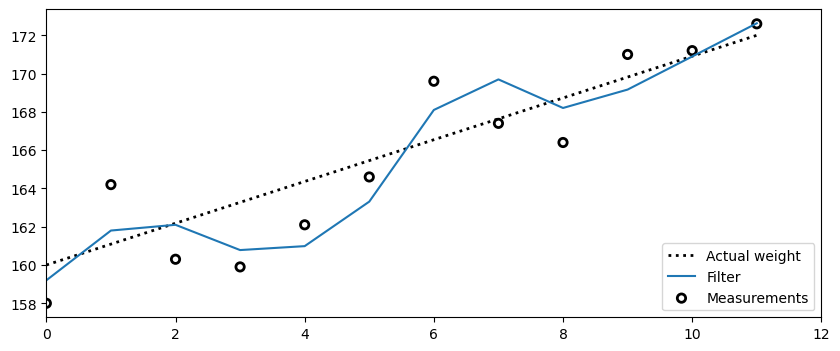

In [66]:
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        
        x_est = x_pred + g * residual

        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)
print(weights)
print(data)

This should have been straightforward. I just subtituted the variable names `x0`, `dx`, etc., for the variable names in the weight gain code. Nothing else needed to change.

Это должно было быть просто. Я просто заменил имена переменных `x0`, `dx` и т. д. на имена переменных в коде набора веса. Больше ничего менять не нужно.

## Choice of $g$ and $h$

The g-h filter is not one filter - it is a classification for a family of filters. Eli Brookner in *Tracking and Kalman Filtering Made Easy* lists 11, and I am sure there are more. Not only that, but each type of filter has numerous subtypes. Each filter is differentiated by how $g$ and $h$ are chosen. So there is no 'one size fits all' advice that I can give here. Some filters set $g$ and $h$ as constants, others vary them dynamically. The Kalman filter varies them dynamically at each step. Some filters allow $g$ and $h$ to take any value within a range, others constrain one to be dependent on the other by some function $f(\dot{}), \mbox{where }g = f(h)$.

The topic of this book is not the entire family of g-h filters; more importantly, we are interested in the *Bayesian* aspect of these filters, which I have not addressed yet. Therefore I will not cover selection of $g$ and $h$ in depth. *Tracking and Kalman Filtering Made Easy* is an excellent resource for that topic. If this strikes you as an odd position for me to take, recognize that the typical formulation of the Kalman filter does not use $g$ and $h$ at all. The Kalman filter is a g-h filter because it mathematically reduces to this algorithm. When we design the Kalman filter we use design criteria that can be mathematically reduced to $g$ and $h$, but the Kalman filter form is usually a much more powerful way to think about the problem. Don't worry if this is not too clear right now, it will clear once we develop the Kalman filter theory.

It is worth seeing how varying $g$ and $h$ affects the results, so we will work through some examples. This will give us strong insight into the fundamental strengths and limitations of this type of filter, and help us understand the behavior of the rather more sophisticated Kalman filter.

Фильтр g-h — это не один фильтр, это классификация для семейства фильтров. Эли Брукнер в книге *Tracking and Kalman Filtering Made Easy* перечисляет 11, и я уверен, что их больше. Более того, каждый тип фильтра имеет множество подтипов. Каждый фильтр отличается тем, как выбираются $g$ и $h$. Поэтому здесь нет универсального совета, который я мог бы дать. Некоторые фильтры устанавливают $g$ и $h$ как константы, другие изменяют их динамически. Фильтр Калмана изменяет их динамически на каждом шаге. Некоторые фильтры позволяют $g$ и $h$ принимать любое значение в пределах диапазона, другие ограничивают один из них зависимостью от другого некоторой функцией $f(\dot{}), \mbox{где }g = f(h)$.

Тема этой книги — не все семейство фильтров g-h; что еще важнее, нас интересует *байесовский* аспект этих фильтров, который я еще не рассматривал. Поэтому я не буду подробно рассматривать выбор $g$ и $h$. *Tracking and Kalman Filtering Made Easy* — отличный ресурс по этой теме. Если вам покажется странной моя позиция, знайте, что типичная формулировка фильтра Калмана вообще не использует $g$ и $h$. Фильтр Калмана — это фильтр g-h, потому что он математически сводится к этому алгоритму. Когда мы проектируем фильтр Калмана, мы используем критерии проектирования, которые можно математически свести к $g$ и $h$, но форма фильтра Калмана обычно является гораздо более мощным способом рассмотрения проблемы. Не волнуйтесь, если сейчас это не совсем понятно, это прояснится, как только мы разработаем теорию фильтра Калмана.

Стоит посмотреть, как изменение $g$ и $h$ влияет на результаты, поэтому мы рассмотрим несколько примеров. Это даст нам четкое представление об основных преимуществах и ограничениях этого типа фильтра и поможет нам понять поведение гораздо более сложного фильтра Калмана.

## Exercise: create measurement function

Now let's write a function that generates noisy data for us. In this book I model a noisy signal as the signal plus [white noise](https://en.wikipedia.org/wiki/White_noise). We've not yet covered the statistics to fully understand the definition of white noise. In essence, think of it as data that randomly varies higher and lower than the signal with no pattern. We say that it is a serially uncorrelated random variable with zero mean and finite variance. If you don't follow that, you will by the end of the *Gaussians* chapter. You may not be successful at this exercise if you have no knowledge of statistics. If so, just read the solution and discussion.

White noise can be generated by `numpy.random.randn()`. We want a function that we call with the starting value, the amount of change per step, the number of steps, and the amount of noise we want to add. It should return a list of the data. Test it by creating 30 points, filtering it with `g_h_filter()`, and plot the results with `plot_g_h_results()`.

Теперь давайте напишем функцию, которая генерирует для нас зашумленные данные. В этой книге я моделирую зашумленный сигнал как сигнал плюс [белый шум](https://en.wikipedia.org/wiki/White_noise). Мы еще не рассмотрели статистику, чтобы полностью понять определение белого шума. По сути, думайте о нем как о данных, которые случайным образом изменяются выше и ниже сигнала без какой-либо закономерности. Мы говорим, что это последовательно некоррелированная случайная величина с нулевым средним и конечной дисперсией. Если вы этого не понимаете, то поймете к концу главы *Гауссианы*. Вы можете не добиться успеха в этом упражнении, если не разбираетесь в статистике. Если так, просто прочитайте решение и обсуждение.

Белый шум может быть сгенерирован с помощью `numpy.random.randn()`. Нам нужна функция, которую мы вызываем с начальным значением, величиной изменения за шаг, количеством шагов и величиной шума, которую мы хотим добавить. Она должна возвращать список данных. Протестируйте его, создав 30 точек, отфильтровав их с помощью `g_h_filter()` и построив график результатов с помощью `plot_g_h_results()`.

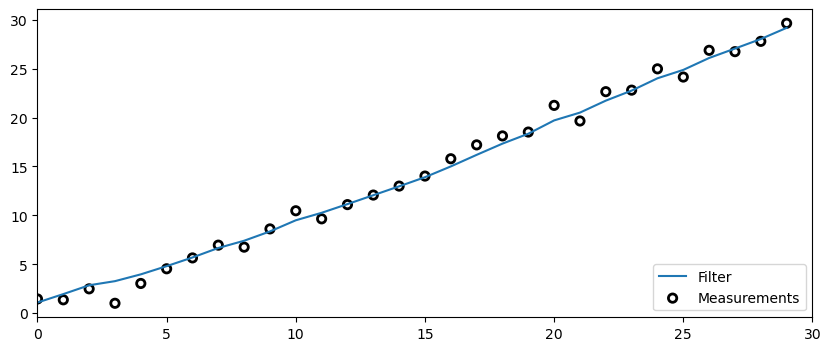

In [80]:
# your code here

def gen_data_self(_x0, _dx, _count, _noice_factor):
    return np.arange(_x0, _x0 + _dx * _count, _dx) + np.random.randn(_count) * _noice_factor

x0 = 0; dx = 1; count=30; noice_factor=1

m = gen_data_self(x0, dx, count, noice_factor)

data = g_h_filter(data=m, x0=x0, dx=dx, g=0.2, h=0.02, dt=1.)
plot_g_h_results(m, data)


### Solution

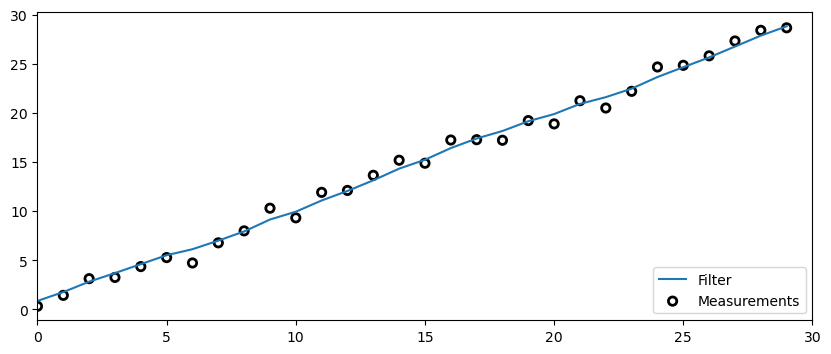

In [79]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### Discussion

`randn()` returns random numbers centered around 0 - it is just as likely to be greater than zero as under zero. It varies by *one standard deviation* - don't worry if you don't know what that means. I've plotted 3000 calls to `randn()` - you can see that the values are centered around zero and mostly range from a bit under -1 to a bit more than +1, though occasionally they are much larger.

`randn()` возвращает случайные числа, центрированные около 0 - вероятность того, что они будут больше нуля, как и меньше нуля, одинакова. Они варьируются на *одно стандартное отклонение* - не волнуйтесь, если вы не знаете, что это значит. Я нанес на график 3000 вызовов `randn()` - вы можете видеть, что значения центрированы около нуля и в основном находятся в диапазоне от немного меньше -1 до немного больше +1, хотя иногда они намного больше.

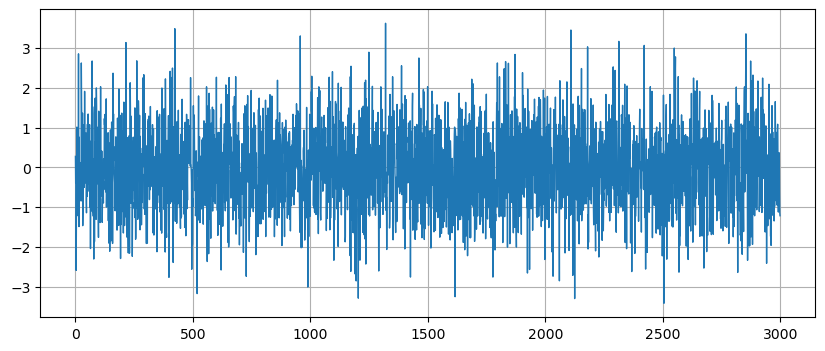

In [25]:
plt.plot([randn() for _ in range(3000)], lw=1);

## Exercise: Bad Initial Conditions

Now write code that uses `gen_data` and `g_h_filter` to filter 100 data points that starts at 5, has a derivative of 2, a noise scaling factor of 10, and uses g=0.2 and h=0.02. Set your initial guess for x to be 100.

Теперь напишите код, который использует `gen_data` и `g_h_filter` для фильтрации 100 точек данных, которые начинаются с 5, имеют производную 2, коэффициент масштабирования шума 10 и используют g=0,2 и h=0,02. Установите начальное предположение для x равным 100.

[  5.197   7.189  18.926   2.459  11.643  14.848   1.479  17.638
   7.961  29.432  38.753  27.664  22.327  40.324  26.93   33.487
  26.662  39.999  39.695  41.487  41.076  36.117  54.197  25.104
  55.261  44.631  70.548  42.551  71.687  49.755  57.756  70.762
  75.281  63.436  75.203  76.645  74.006  75.497  94.637  70.396
  84.562  92.934  86.719  93.237  90.99   87.725  90.957  81.201
  92.74  107.879 107.087 109.129 104.481 117.085 101.68  126.107
 111.841 124.32  130.738 124.127 134.752 118.778 128.163 132.045
 120.423 124.373 129.297 146.152 152.869 148.071 128.462 145.085
 151.811 167.824 159.819 160.442 168.553 158.334 170.092 171.677
 156.846 172.599 157.464 181.854 175.537 171.333 172.019 174.208
 171.58  179.961 178.139 178.625 182.268 196.452 211.508 189.365
 195.834 204.89  205.174 205.05 ]


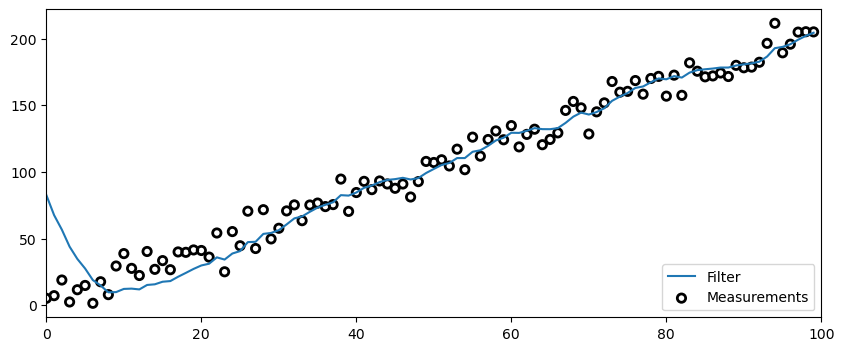

In [86]:
# your code here
x0 = 5; dx = 2; p_count = 100; noice_factor = 10

m = gen_data_self(_x0=x0, _dx=dx, _count=p_count, _noice_factor=noice_factor)

print(m)

data = g_h_filter(data=m, x0=100, dx=dx, dt=1, g=0.2, h=0.02)
plot_g_h_results(m, data)

### Solution and Discussion

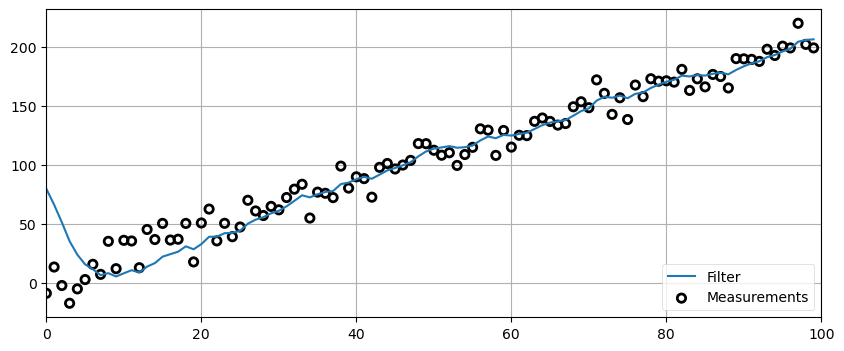

In [27]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

The filter starts out with estimates that are far from the measured data due to the bad initial guess of 100. You can see that it 'rings' before settling in on the measured data. 'Ringing' means that the signal overshoots and undershoots the data in a sinusoidal type pattern. This is a very common phenomena in filters, and a lot of work in filter design is devoted to minimizing ringing. That is a topic that we are not yet prepared to address, but I wanted to show you the phenomenon.

Фильтр начинает с оценок, которые далеки от измеренных данных из-за плохого начального предположения 100. Вы можете видеть, что он «звенит», прежде чем остановиться на измеренных данных. «Звенит» означает, что сигнал превышает и ниже данных в шаблоне синусоидального типа. Это очень распространенное явление в фильтрах, и большая часть работы при проектировании фильтров посвящена минимизации звона. Это тема, к которой мы пока не готовы обратиться, но я хотел показать вам это явление.

## Exercise: Extreme Noise

Rerun the same test, but this time use a noise factor of 100. Remove the initial condition ringing by changing the initial condition from 100 down to 5.

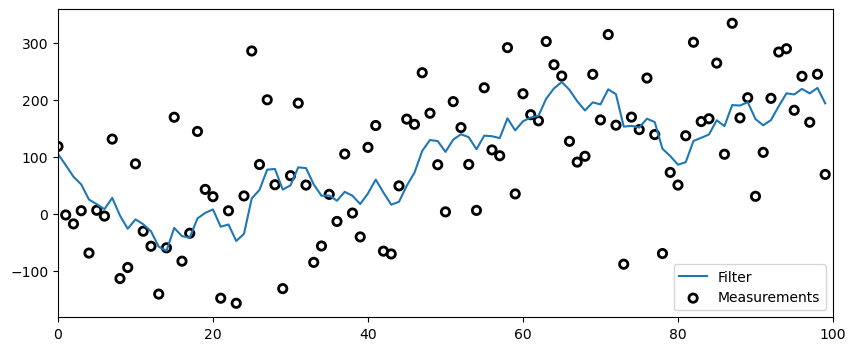

In [88]:
# your code here
m = gen_data_self(_x0=x0, _dx=dx, _count=p_count, _noice_factor=100)
data = g_h_filter(data=m, x0=100, dx=dx, dt=1, g=0.2, h=0.02)
plot_g_h_results(m, data)

### Solution and Discussion

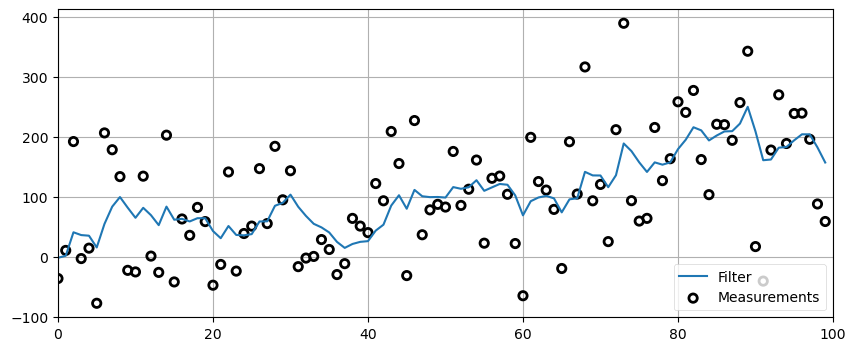

In [29]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

This doesn't look so wonderful to me. We can see that perhaps the filtered signal varies less than the noisy signal, but it is far from the straight line. If we were to plot just the filtered result no one would guess that the signal starts at 5 and increments by 2 at each time step. And while in locations the filter does seem to reduce the noise, in other places it seems to overshoot and undershoot.

At this point we don't know enough to really judge this. We added **a lot** of noise; maybe this is as good as filtering can get. However, the existence of the multitude of chapters beyond this one should suggest that we can do much better.

Мне это не кажется таким уж замечательным. Мы видим, что, возможно, отфильтрованный сигнал изменяется меньше, чем зашумленный сигнал, но он далек от прямой линии. Если бы мы отобразили на графике только отфильтрованный результат, никто бы не догадался, что сигнал начинается с 5 и увеличивается на 2 на каждом временном шаге. И хотя в некоторых местах фильтр, похоже, уменьшает шум, в других местах он, похоже, перескакивает или недоскакивает.

На данный момент мы не знаем достаточно, чтобы действительно судить об этом. Мы добавили **много** шума; возможно, это так хорошо, как может фильтрация. Однако существование множества глав после этой должно предполагать, что мы можем сделать гораздо лучше.

## Exercise: The Effect of Acceleration

Write a new data generation function that adds in a constant acceleration factor to each data point. In other words, increment dx as you compute each data point so that the velocity (dx) is ever increasing. Set the noise to 0, $g=0.2$ and $h=0.02$ and plot the results using `plot_g_h_results` or your own routine. Play around with different accererations and times steps. Explain what you see.

Напишите новую функцию генерации данных, которая добавляет постоянный фактор ускорения к каждой точке данных. Другими словами, увеличивайте dx по мере вычисления каждой точки данных, чтобы скорость (dx) постоянно увеличивалась. Установите шум на 0, $g=0.2$ и $h=0.02$ и постройте график результатов с помощью `plot_g_h_results` или вашей собственной процедуры. Поиграйтесь с различными ускорениями и временными шагами. Объясните, что вы видите.

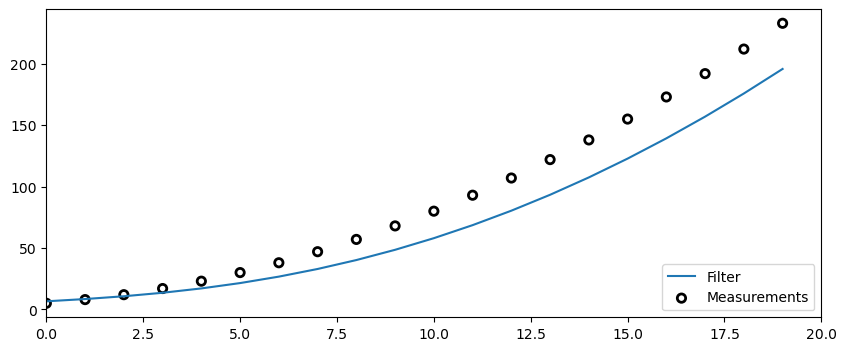

In [93]:
# your code here
def gen_data_self_axel(_x0, _dx, _axel, _count, _noice_factor):
    return np.arange(_x0, _x0 + _dx * _count, _dx) + np.random.randn(_count) * _noice_factor + np.cumsum(np.arange(0,  _axel * _count, _axel))

m = gen_data_self_axel(_x0=x0, _dx=dx, _axel=1, _count=20, _noice_factor=0)
data = g_h_filter(data=m, x0=5, dx=dx, dt=1, g=0.2, h=0.02)
plot_g_h_results(m, data)

### Solution and Discussion

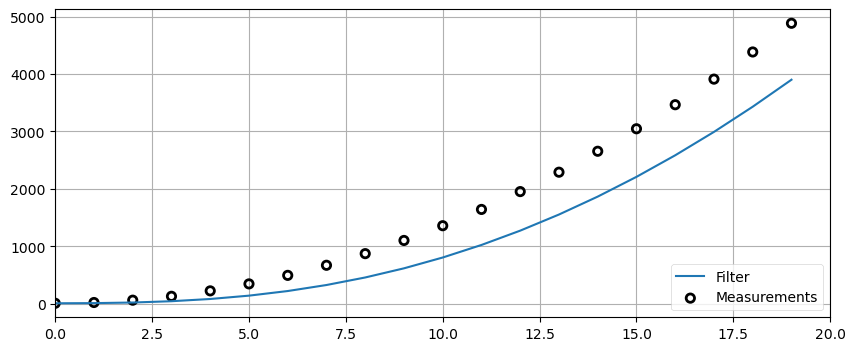

In [31]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + accel * (i**2) / 2 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=9.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

Each prediction lags behind the signal. If you think about what is happening this makes sense. Our model assumes that velocity is constant. The g-h filter computes the first derivative of $x$ (we use $\dot{x}$ to denote the derivative) but not the second derivative $\ddot{x}$. So we are assuming that $\ddot{x}=0$. At each prediction step we predict the new value of x as $x + \dot{x}*t$. But because of the acceleration the prediction must necessarily fall behind the actual value. We then try to compute a new value for $\dot{x}$, but because of the $h$ factor we only partially adjust $\dot{x}$ to the new velocity. On the next iteration we will again fall short.

Note that there is no adjustment to $g$ or $h$ that we can make to correct this problem. This is called the *lag error* or *systemic error* of the system. It is a fundamental property of g-h filters. Perhaps your mind is already suggesting solutions or workarounds to this problem. As you might expect, a lot of research has been devoted to this problem, and we will be presenting various solutions to this problem in this book.
> The 'take home' point is that the filter is only as good as the mathematical model used to express the system. 

Каждое предсказание отстает от сигнала. Если вы задумаетесь о том, что происходит, это имеет смысл. Наша модель предполагает, что скорость постоянна. Фильтр g-h вычисляет первую производную $x$ (мы используем $\dot{x}$ для обозначения производной), но не вторую производную $\ddot{x}$. Поэтому мы предполагаем, что $\ddot{x}=0$. На каждом шаге предсказания мы предсказываем новое значение x как $x + \dot{x}*t$. Но из-за ускорения предсказание обязательно должно отставать от фактического значения. Затем мы пытаемся вычислить новое значение для $\dot{x}$, но из-за фактора $h$ мы лишь частично подстраиваем $\dot{x}$ под новую скорость. На следующей итерации мы снова не дотягиваем.

Обратите внимание, что нет никакой корректировки $g$ или $h$, которую мы могли бы сделать, чтобы исправить эту проблему. Это называется *ошибкой запаздывания* или *системной ошибкой* системы. Это фундаментальное свойство фильтров g-h. Возможно, ваш разум уже предлагает решения или обходные пути для этой проблемы. Как вы могли ожидать, этой проблеме было посвящено много исследований, и мы представим различные решения этой проблемы в этой книге.
> Главное, что следует усвоить, заключается в том, что фильтр настолько хорош, насколько хороша математическая модель, используемая для выражения системы.

## Exercise: Varying $g$

Now let's look at the effect of varying $g$. Before you perform this exercise, recall that $g$ is the scale factor for choosing between the measurement and prediction. What do you think the effect of a large value of $g$ will be? A small value?

Now, let the `noise_factor=50` and `dx=5`. Plot the results of $g = 0.1\mbox{, } 0.4,\mbox{ and } 0.8$.

Теперь давайте рассмотрим эффект изменения $g$. Перед тем, как выполнить это упражнение, вспомните, что $g$ — это масштабный коэффициент для выбора между измерением и прогнозом. Как вы думаете, каким будет эффект большого значения $g$? Малого значения?

Теперь пусть `noise_factor=50` и `dx=5`. Постройте графики результатов $g = 0,1\mbox{, } 0,4,\mbox{ и } 0,8$.

In [32]:
# your code here

### Solution and Discussion

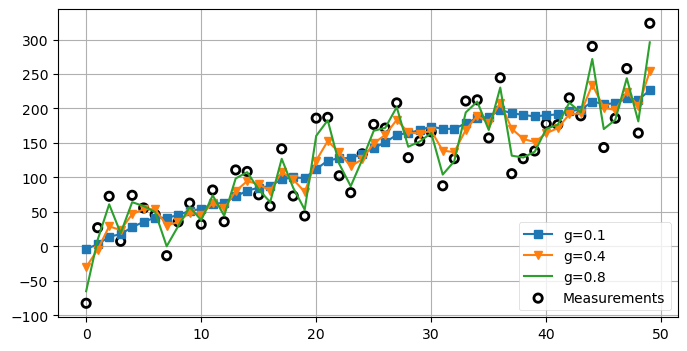

In [33]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)

It is clear that as $g$ is larger we more closely follow the measurement instead of the prediction. When $g=0.8$ we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that $g$ should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction. What happens when the signal changes not due to noise, but an actual state change? Let's have a look. I will create data that has $\dot{x}=1$ for 9 steps before changing to $\dot{x}=0$. 

Очевидно, что чем больше $g$, тем ближе мы следуем измерению, а не прогнозу. Когда $g=0,8$, мы почти точно следуем сигналу и почти не отклоняем шум. Можно наивно заключить, что $g$ всегда должно быть очень маленьким, чтобы максимально подавлять шум. Однако это означает, что мы в основном игнорируем измерения в пользу нашего прогноза. Что происходит, когда сигнал изменяется не из-за шума, а из-за фактического изменения состояния? Давайте посмотрим. Я создам данные, в которых $\dot{x}=1$ для 9 шагов, прежде чем измениться на $\dot{x}=0$.

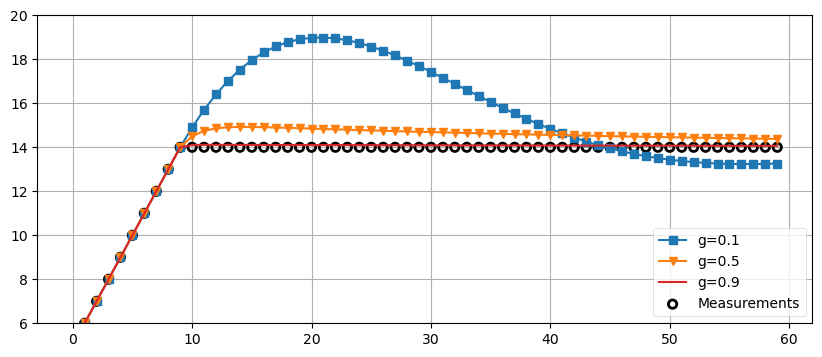

In [34]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

Here we can see the effects of ignoring the signal. We not only filter out noise, but legitimate changes in the signal as well. 

Maybe we need a 'Goldilocks' filter, where $g$ is not too large, not too small, but just right? Well, not exactly. As alluded to earlier, different filters choose $g$ and $h$ in different ways depending on the mathematical properties of the problem. For example, the Benedict-Bordner filter was invented to minimize the transient error in this example, where $\dot{x}$ makes a step jump. We will not discuss this filter in this book, but here are two plots chosen with different allowable pairs of $g$ and $h$. This filter design minimizes transient errors for step jumps in $\dot{x}$ at the cost of not being optimal for other types of changes in $\dot{x}$.

Здесь мы можем увидеть эффекты игнорирования сигнала. Мы не только отфильтровываем шум, но и законные изменения сигнала.

Может быть, нам нужен фильтр «Златовласки», где $g$ не слишком большой, не слишком маленький, а как раз подходящий? Ну, не совсем. Как упоминалось ранее, разные фильтры выбирают $g$ и $h$ по-разному в зависимости от математических свойств задачи. Например, фильтр Бенедикта-Борднера был изобретен для минимизации переходной ошибки в этом примере, где $\dot{x}$ делает скачок шага. Мы не будем обсуждать этот фильтр в этой книге, но вот два графика, выбранных с различными допустимыми парами $g$ и $h$. Такая конструкция фильтра минимизирует переходные ошибки для скачков шага в $\dot{x}$ ценой того, что она не является оптимальной для других типов изменений в $\dot{x}$.

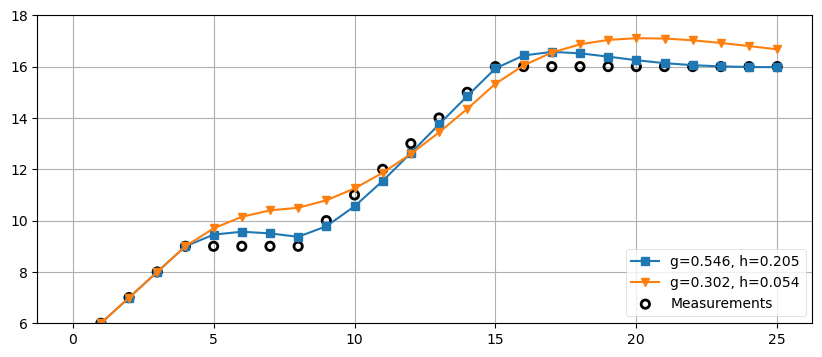

In [35]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## Varying $h$

Now let's leave $g$ unchanged and investigate the effect of modifying $h$. We know that $h$ affects how much we favor the measurement of $\dot{x}$ vs our prediction. But what does this *mean*? If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those transient changes rapidly. A smaller $h$ will cause us to react more slowly.

We will look at three examples. We have a noiseless measurement that slowly goes from 0 to 1 in 50 steps. Our first filter uses a nearly correct initial value for $\dot{x}$ and a small $h$. You can see from the output that the filter output is very close to the signal. The second filter uses the very incorrect guess of $\dot{x}=2$. Here we see the filter 'ringing' until it settles down and finds the signal. The third filter uses the same conditions but it now sets $h=0.5$. If you look at the amplitude of the ringing you can see that it is much smaller than in the second chart, but the frequency is greater. It also settles down a bit quicker than the second filter, though not by much.

Теперь оставим $g$ без изменений и исследуем эффект изменения $h$. Мы знаем, что $h$ влияет на то, насколько мы предпочитаем измерение $\dot{x}$ нашему прогнозу. Но что это *означает*? Если наш сигнал сильно меняется (быстро относительно временного шага нашего фильтра), то большое $h$ заставит нас быстро реагировать на эти переходные изменения. Меньшее $h$ заставит нас реагировать медленнее.

Мы рассмотрим три примера. У нас есть бесшумное измерение, которое медленно переходит от 0 до 1 за 50 шагов. Наш первый фильтр использует почти правильное начальное значение для $\dot{x}$ и небольшое $h$. Из выходных данных видно, что выход фильтра очень близок к сигналу. Второй фильтр использует очень неправильное предположение $\dot{x}=2$. Здесь мы видим, как фильтр «звенит», пока не успокоится и не найдет сигнал. Третий фильтр использует те же условия, но теперь он устанавливает $h=0,5$. Если посмотреть на амплитуду звона, то можно увидеть, что она намного меньше, чем на второй диаграмме, но частота больше. Она также немного быстрее успокаивается, чем второй фильтр, хотя и не намного.

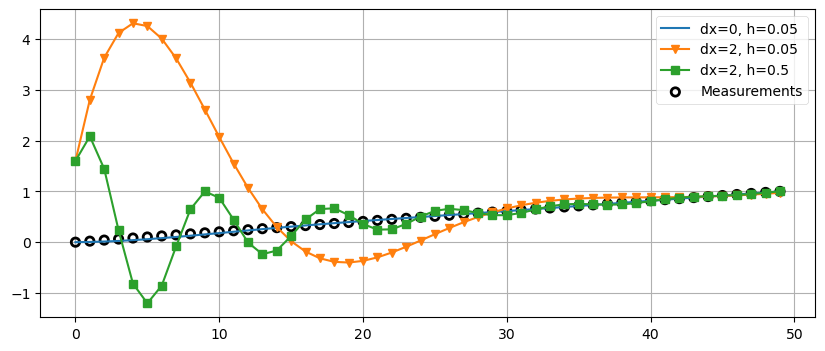

In [36]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## Interactive Example

For those of you running this in Jupyter Notebook I've written an interactive version of the filter so you can see the effect of changing $\dot{x}$, $g$ and $h$ in real time. As you adjust the sliders for $\dot{x}$, $g$ and $h$ the data will be refiltered and the results plotted for you.

If you really want to test yourself, read the next paragraph and try to predict the results before you move the sliders. 

Some things to try include setting $g$  and $h$ to their minimum values. See how perfectly the filter tracks the data! This is only because we are perfectly predicting the weight gain. Adjust $\dot{x}$ to larger or smaller than 5. The filter should diverge from the data and never reacquire it. Start adding back either $g$ or $h$ and see how the filter snaps back to the data. See what the difference in the line is when you add only $g$ vs only $h$. Can you explain the reason for the difference? Then try setting $g$ greater than 1. Can you explain the results? Put $g$ back to a reasonable value (such as 0.1), and then make $h$ very large. Can you explain these results? Finally, set both $g$ and $h$ to their largest values. 
 
If you want to explore with this more, change the value of the array `zs` to the values used in any of the charts above and rerun the cell to see the result.

Для тех из вас, кто запускает это в Jupyter Notebook, я написал интерактивную версию фильтра, чтобы вы могли увидеть эффект изменения $\dot{x}$, $g$ и $h$ в реальном времени. Когда вы настраиваете ползунки для $\dot{x}$, $g$ и $h$, данные будут повторно отфильтрованы, а результаты построены для вас.

Если вы действительно хотите проверить себя, прочитайте следующий абзац и попробуйте предсказать результаты, прежде чем перемещать ползунки.

Некоторые вещи, которые стоит попробовать, включают установку $g$ и $h$ на их минимальные значения. Посмотрите, насколько идеально фильтр отслеживает данные! Это только потому, что мы идеально предсказываем увеличение веса. Измените $\dot{x}$ на большее или меньшее 5. Фильтр должен расходиться с данными и никогда не получать их снова. Начните добавлять обратно либо $g$, либо $h$ и посмотрите, как фильтр возвращается к данным. Посмотрите, какая разница в линии, когда вы добавляете только $g$ по сравнению с только $h$. Можете ли вы объяснить причину разницы? Затем попробуйте установить $g$ больше 1. Можете ли вы объяснить результаты? Верните $g$ к разумному значению (например, 0,1), а затем сделайте $h$ очень большим. Можете ли вы объяснить эти результаты? Наконец, установите и $g$, и $h$ на их самые большие значения.

Если вы хотите изучить это подробнее, измените значение массива `zs` на значения, используемые в любой из диаграмм выше, и перезапустите ячейку, чтобы увидеть результат.

In [94]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')
    plt.show()

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

## Don't Lie to the Filter

You are free to set $g$ and $h$ to any value. Here is a filter that performs perfectly despite extreme noise.

Вы можете установить $g$ и $h$ на любое значение. Вот фильтр, который работает идеально, несмотря на экстремальный шум.

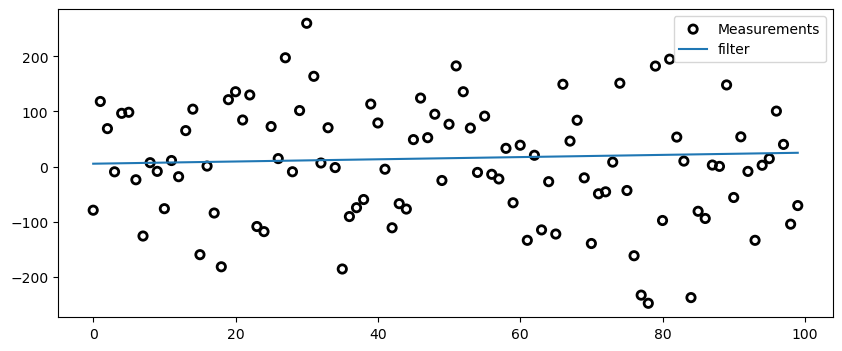

In [95]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

I brilliantly extracted a straight line out of very noisy data! Maybe I shouldn't try to collect my Fields Medal in mathematics just yet. I did this by setting both $g$ and $h$ to 0. What does this do? It makes the filter ignore the measurements, and so for each update it computes the new position as $x + \Delta x \Delta t$. Of course the result is a straight line if we ignore the measurements. 

A filter that ignores measurements is useless. I know you would never set both $g$ and $h$ to zero as that takes a special kind of genius that only I possess, but I promise that if you are not careful you will set them lower than they should be. You can always make great looking results from test data. When you try your filter on different data you will be disappointed in the results because you finely tuned the constants for a specific data set. $g$ and $h$ must reflect the real world behavior of the system you are filtering, not the behavior of one specific data set. In later chapters we will learn a lot about how to do that. For now I can only say be careful, or you will be getting perfect results with your test data, but results like this once you switch to real data:

Я блестяще извлек прямую линию из очень шумных данных! Возможно, мне пока не стоит пытаться получить свою медаль Филдса по математике. Я сделал это, установив $g$ и $h$ на 0. Что это делает? Это заставляет фильтр игнорировать измерения, и поэтому для каждого обновления он вычисляет новое положение как $x + \Delta x \Delta t$. Конечно, результатом будет прямая линия, если мы проигнорируем измерения.

Фильтр, который игнорирует измерения, бесполезен. Я знаю, что вы никогда не установите оба $g$ и $h$ на ноль, поскольку это требует особого рода гения, которым обладаю только я, но я обещаю, что если вы не будете осторожны, вы установите их ниже, чем они должны быть. Вы всегда можете получить великолепные результаты из тестовых данных. Когда вы попробуете свой фильтр на других данных, вы будете разочарованы результатами, потому что вы точно настроили константы для определенного набора данных. $g$ и $h$ должны отражать реальное поведение системы, которую вы фильтруете, а не поведение одного конкретного набора данных. В последующих главах мы много узнаем о том, как это сделать. Сейчас я могу только сказать: будьте осторожны, иначе вы получите идеальные результаты с вашими тестовыми данными, но результаты вроде этих, как только вы перейдете к реальным данным:

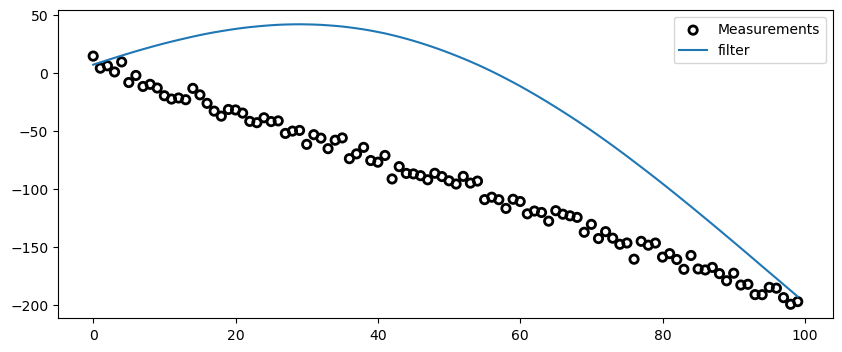

In [96]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## Tracking a Train

We are ready for a practical example. Earlier in the chapter we talked about tracking a train. Trains are heavy and slow, thus they cannot change speed quickly. They are on a track, so they cannot change direction except by slowing to a stop and then reversing course. Hence, we can conclude that if we already know the train's approximate position and velocity then we can predict its position in the near future with a great deal of accuracy. A train cannot change its velocity much in a second or two. 

So let's write a filter for a train. Its position is expressed as its position on the track in relation to some fixed point which we say is 0 km. I.e., a position of 1 means that the train is 1 km away from the fixed point. Velocity is expressed as meters per second. We perform measurement of position once per second, and the error is $\pm$ 500 meters. How should we implement our filter?

First, let's simulate the situation without a filter. We will assume that the train is currently at kilometer 23, and moving at 15 m/s. We can code this as 

Мы готовы к практическому примеру. Ранее в этой главе мы говорили об отслеживании поезда. Поезда тяжелые и медленные, поэтому они не могут быстро менять скорость. Они находятся на рельсах, поэтому они не могут изменить направление, кроме как замедлившись до остановки и затем изменив курс. Следовательно, мы можем сделать вывод, что если мы уже знаем приблизительное положение и скорость поезда, то мы можем предсказать его положение в ближайшем будущем с большой точностью. Поезд не может сильно изменить свою скорость за секунду или две.

Итак, давайте напишем фильтр для поезда. Его положение выражается как его положение на пути относительно некоторой фиксированной точки, которую мы называем 0 км. То есть положение 1 означает, что поезд находится на расстоянии 1 км от фиксированной точки. Скорость выражается в метрах в секунду. Мы выполняем измерение положения один раз в секунду, и погрешность составляет $\pm$ 500 метров. Как нам реализовать наш фильтр?

Сначала давайте смоделируем ситуацию без фильтра. Предположим, что поезд в данный момент находится на 23-м километре и движется со скоростью 15 м/с. Мы можем закодировать это как

```python
pos = 23*1000
vel = 15
```

Now we can compute the position of the train at some future time, *assuming* no change in velocity, with

Теперь мы можем вычислить положение поезда в будущем, *предполагая*, что скорость не изменится, с помощью

```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```

We can simulate the measurement by adding in some random noise to the position. Here our error is 500m, so the code might look like:

Мы можем смоделировать измерение, добавив случайный шум к позиции. Здесь наша ошибка составляет 500 м, поэтому код может выглядеть так:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
        
Let's put that in a cell and plot the results of 100 seconds of simulation. I will use NumPy's `asarray` function to convert the data into an NumPy array. This will allow me to divide all of the elements of the array at once by using the '/' operator.

Давайте поместим это в ячейку и построим график результатов 100 секунд моделирования. Я буду использовать функцию `asarray` NumPy для преобразования данных в массив NumPy. Это позволит мне разделить все элементы массива одновременно с помощью оператора '/'.

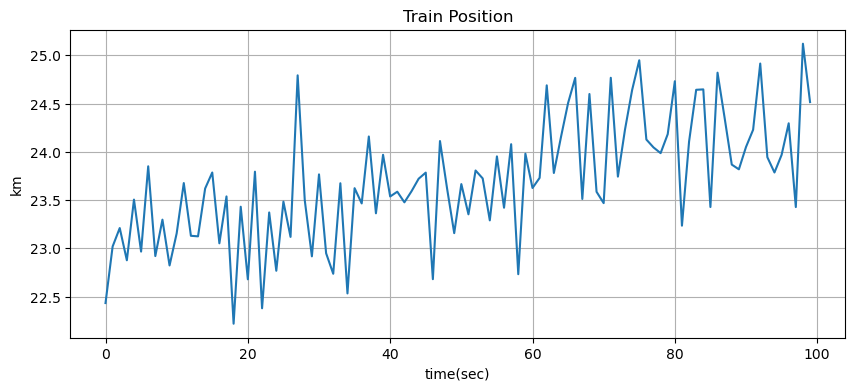

In [40]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

We can see from the chart how poor the measurements are. No real train could ever move like that. 

So what should we set $g$ and $h$ to if we want to filter this data? We have not developed the theory for this, but let's try to get a reasonable answer by the seat of our pants. We know that the measurements are very inaccurate, so we don't want to give them much weight at all. To do this we need to choose a very small $g$. We also know that trains can not accelerate or decelerate quickly, so we also want a very small $h$. For example:

Из графика видно, насколько плохи измерения. Ни один реальный поезд не мог бы так двигаться.

Так что же нам следует задать для $g$ и $h$, если мы хотим отфильтровать эти данные? Мы не разработали теорию для этого, но давайте попробуем получить разумный ответ на месте наших штанов. Мы знаем, что измерения очень неточны, поэтому мы вообще не хотим придавать им большого веса. Для этого нам нужно выбрать очень маленькое $g$. Мы также знаем, что поезда не могут быстро ускоряться или замедляться, поэтому нам также нужно очень маленькое $h$. Например:

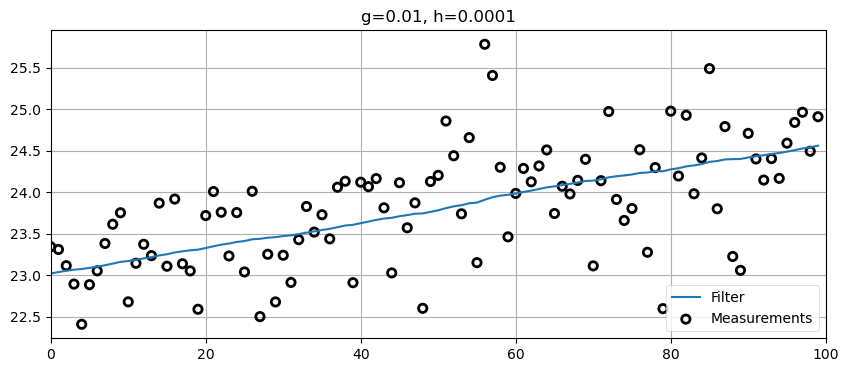

In [41]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

That is pretty good for an initial guess. Let's make $g$ larger to see the effect.

Это довольно хорошо для первоначальной догадки. Давайте сделаем $g$ больше, чтобы увидеть эффект

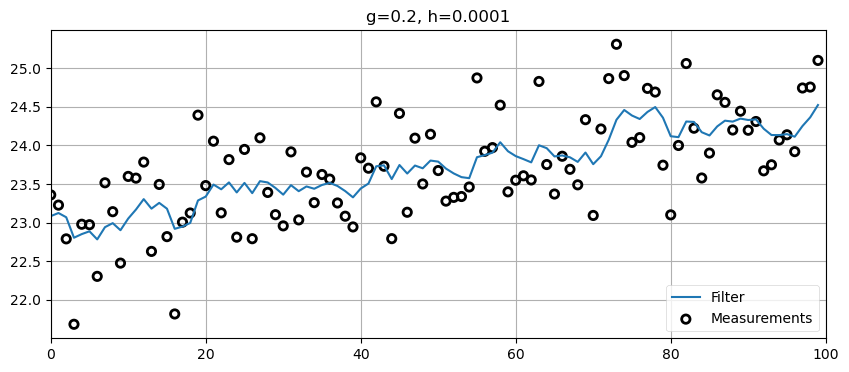

In [42]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

We made `g=0.2` and we can see that while the train's position is smoothed, the estimated position (and hence velocity) fluctuates a lot in a very tiny frame, far more than a real train can do. So empirically we know that we want `g<<0.2`.

Now let's see the effect of a poor choice for $h$.

Мы сделали `g=0.2` и видим, что хотя положение поезда сглажено, предполагаемое положение (и, следовательно, скорость) сильно колеблется в очень маленьком кадре, гораздо больше, чем может сделать реальный поезд. Поэтому эмпирически мы знаем, что нам нужно `g<<0.2`.

Теперь давайте посмотрим на эффект плохого выбора для $h$.

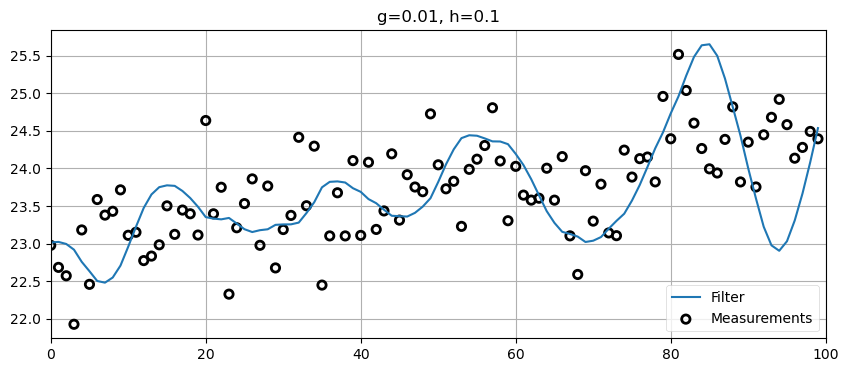

In [43]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

Here the position changes smoothly thanks to the small $g$, but the large $h$ makes the filter very reactive to the measurements. This happens because in the course of a few seconds the rapidly changing measurement implies a very large velocity change, and a large $h$ tells the filter to react to those changes quickly. Trains cannot change velocity quickly, so the filter is not doing a good job of filtering the data - the filter is changing velocity faster than a train can.

Finally, let's add some acceleration to the train. I don't know how fast a train can actually accelerate, but let's say it is accelerating at 0.2 m/sec^2. 

Здесь положение плавно меняется благодаря малому $g$, но большое $h$ делает фильтр очень чувствительным к измерениям. Это происходит потому, что в течение нескольких секунд быстро меняющееся измерение подразумевает очень большое изменение скорости, а большое $h$ говорит фильтру быстро реагировать на эти изменения. Поезда не могут быстро менять скорость, поэтому фильтр не справляется с фильтрацией данных — фильтр меняет скорость быстрее, чем поезд.

Наконец, давайте добавим немного ускорения поезду. Я не знаю, насколько быстро поезд может разгоняться на самом деле, но предположим, что он разгоняется со скоростью 0,2 м/сек^2.

In [44]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

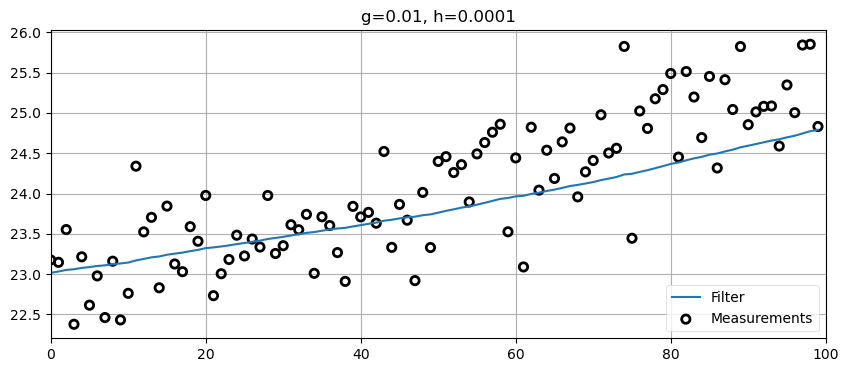

In [45]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Here we see that the filter is not quite tracking the train anymore due to the acceleration. We can fiddle with $h$ to let it track better, at the expense of a less smooth filtered estimate.

Здесь мы видим, что фильтр больше не отслеживает поезд из-за ускорения. Мы можем поиграть с $h$, чтобы он лучше отслеживал, за счет менее гладкой отфильтрованной оценки.

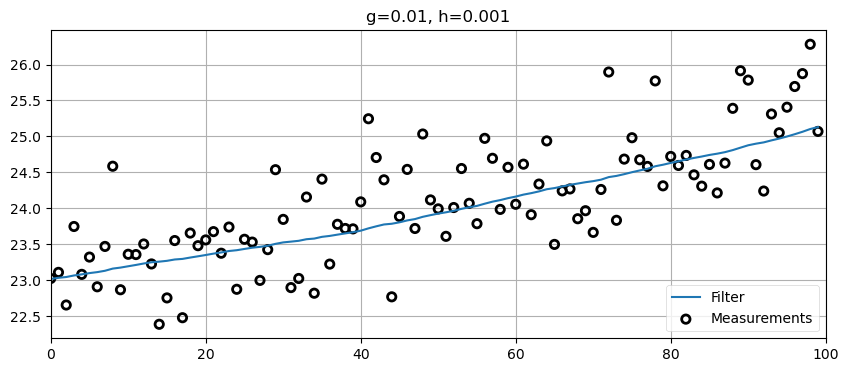

In [46]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

There are two lessons to be learned here. First, use the $h$ term to respond to changes in velocity that you are not modeling. But, far more importantly, there is a trade off here between responding quickly and accurately to changes in behavior and producing ideal output for when the system is in a steady state that you have. If the train never changes velocity we would make $h$ extremely small to avoid having the filtered estimate unduly affected by the noise in the measurement. But in an interesting problem there are almost always changes in state, and we want to react to them quickly. The more quickly we react to them, the more we are affected by the noise in the sensors. 

I could go on, but my aim is not to develop g-h filter theory here so much as to build insight into how combining measurements and predictions leads to a filtered solution. There is extensive literature on choosing $g$ and $h$ for problems such as this, and there are optimal ways of choosing them to achieve various goals. As I explained earlier it is easy to 'lie' to the filter when experimenting with test data like this. In the subsequent chapters we will learn how the Kalman filter solves this problem in the same basic manner, but with far more sophisticated mathematics. 

Здесь нужно усвоить два урока. Во-первых, используйте термин $h$ для реагирования на изменения скорости, которые вы не моделируете. Но, что гораздо важнее, здесь есть компромисс между быстрым и точным реагированием на изменения поведения и созданием идеального выходного сигнала для случая, когда система находится в устойчивом состоянии, которое у вас есть. Если поезд никогда не меняет скорость, мы бы сделали $h$ чрезвычайно малым, чтобы избежать ненужного влияния шума в измерении на отфильтрованную оценку. Но в интересной задаче почти всегда есть изменения состояния, и мы хотим быстро на них реагировать. Чем быстрее мы на них реагируем, тем больше на нас влияет шум в датчиках.

Я мог бы продолжать, но моя цель здесь не столько развить теорию фильтра g-h, сколько понять, как объединение измерений и прогнозов приводит к отфильтрованному решению. Существует обширная литература по выбору $g$ и $h$ для таких задач, как эта, и существуют оптимальные способы их выбора для достижения различных целей. Как я уже объяснял ранее, легко «солгать» фильтру при экспериментировании с такими тестовыми данными. В последующих главах мы узнаем, как фильтр Калмана решает эту задачу тем же базовым способом, но с использованием гораздо более сложной математики.

## g-h Filters with FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) is an open source filtering library that I wrote. It has all of the filters in this book, along with others. It is rather easy to program your own g-h filter, but as we progress we will rely on FilterPy more. As a quick introduction, let's look at the g-h filter in FilterPy.

If you do not have FilterPy installed just issue the following command from the command line.

    pip install filterpy
    
Read Appendix A for more information on installing or downloading FilterPy from GitHub.

To use the g-h filter import it and create an object from the class `GHFilter`. 

[FilterPy](https://github.com/rlabbe/filterpy) — это библиотека фильтрации с открытым исходным кодом, которую я написал. Она содержит все фильтры из этой книги, а также другие. Довольно легко запрограммировать свой собственный фильтр g-h, но по мере продвижения мы будем больше полагаться на FilterPy. В качестве быстрого введения давайте рассмотрим фильтр g-h в FilterPy.

Если у вас не установлен FilterPy, просто выполните следующую команду из командной строки.

pip install filterpy

Прочтите Приложение A для получения дополнительной информации об установке или загрузке FilterPy с GitHub.

Чтобы использовать фильтр g-h, импортируйте его и создайте объект из класса `GHFilter`.

In [97]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

When you construct the object you specify the initial value and rate of change for the signal (`x` and 'dx'), the time step between updates(`dt`) and the two filter parameter (`g` and `h`). `dx` must have the same units of `x`/`dt` - if `x` is in meters and `dt` is in seconds then `dx` must be in meters per second.

To run the filter call update, passing the measurement in the parameter `z`, which you'll recall is a standard name for measurements in the literature.

При создании объекта вы указываете начальное значение и скорость изменения сигнала (`x` и 'dx'), временной шаг между обновлениями (`dt`) и два параметра фильтра (`g` и `h`). `dx` должен иметь те же единицы измерения `x`/`dt` - если `x` в метрах, а `dt` в секундах, то `dx` должен быть в метрах в секунду.

Чтобы запустить вызов фильтра, передайте измерение в параметре `z`, который, как вы помните, является стандартным названием для измерений в литературе.

In [48]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [49]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [50]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [51]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [52]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

Класс `GHFilterOrder` позволяет вам создать фильтр порядка 0, 1 или 2. Фильтр g-h имеет порядок 1. Фильтр g-h-k, о котором мы не говорили, также отслеживает ускорения. Оба класса имеют функциональность, необходимую для реальных приложений, например, вычисление фактора снижения дисперсии (VRF), который мы не обсуждали в этой главе. Я мог бы заполнить книгу только по теории и применению фильтров g-h, но у нас есть и другие цели в этой книге. Если вам интересно, изучите код FilterPy и прочтите что-нибудь еще.

Документация по FilterPy находится по адресу https://filterpy.readthedocs.org/.

## Summary

I encourage you to experiment with this filter to develop your understanding of how it reacts. It shouldn't take too many attempts to come to the realization that ad-hoc choices for $g$ and $h$ do not perform very well. A particular choice might perform well in one situation, but very poorly in another. Even when you understand the effect of $g$ and $h$ it can be difficult to choose proper values. In fact, it is extremely unlikely that you will choose values for $g$ and $h$ that is optimal for any given problem. Filters are *designed*, not selected *ad hoc*. 

In some ways I do not want to end the chapter here, as there is a significant amount that we can say about selecting $g$ and $h$. But the g-h filter in this form is not the purpose of this book. Designing the Kalman filter requires you to specify a number of parameters - indirectly they do relate to choosing $g$ and $h$, but you will never refer to them directly when designing Kalman filters. Furthermore, $g$ and $h$ will vary at every time step in a very non-obvious manner. 

There is another feature of these filters we have barely touched upon - Bayesian statistics. You will note that the term 'Bayesian' is in the title of this book; this is not a coincidence! For the time being we will leave $g$ and $h$ behind, largely unexplored, and develop a very powerful form of probabilistic reasoning about filtering. Yet suddenly this same g-h filter algorithm will appear, this time with a formal mathematical edifice that allows us to create filters from multiple sensors, to accurately estimate the amount of error in our solution, and to control robots.

Я призываю вас поэкспериментировать с этим фильтром, чтобы развить понимание того, как он реагирует. Не должно потребоваться слишком много попыток, чтобы прийти к пониманию того, что выбор ad hoc для $g$ и $h$ не очень хорошо работает. Конкретный выбор может хорошо работать в одной ситуации, но очень плохо в другой. Даже когда вы понимаете влияние $g$ и $h$, может быть сложно выбрать правильные значения. На самом деле, крайне маловероятно, что вы выберете значения для $g$ и $h$, которые оптимальны для любой данной проблемы. Фильтры *разрабатываются*, а не выбираются *ad hoc*.

В некотором смысле я не хочу заканчивать главу здесь, так как есть значительное количество того, что мы можем сказать о выборе $g$ и $h$. Но фильтр g-h в этой форме не является целью этой книги. Проектирование фильтра Калмана требует от вас указания ряда параметров — косвенно они связаны с выбором $g$ и $h$, но вы никогда не будете ссылаться на них напрямую при проектировании фильтров Калмана. Более того, $g$ и $h$ будут меняться на каждом временном шаге весьма неочевидным образом.

Есть еще одна особенность этих фильтров, которую мы едва коснулись — байесовская статистика. Вы заметите, что термин «байесовский» есть в названии этой книги; это не совпадение! На данный момент мы оставим $g$ и $h$ позади, в значительной степени неисследованными, и разработаем очень мощную форму вероятностного рассуждения о фильтрации. Однако внезапно появится тот же самый алгоритм фильтра g-h, на этот раз с формальным математическим зданием, которое позволит нам создавать фильтры из нескольких датчиков, точно оценивать количество ошибок в нашем решении и управлять роботами.